In [1]:
import numpy as np
from time import time
import time
import os
import sys
import scipy
import math
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
import scipy as sp
import scipy.ndimage
from tqdm import tqdm
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
from scipy.signal import convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model
from sklearn.decomposition import FastICA

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline
plt.rcParams.update({'font.size': 20})

In [2]:
plt.rcParams.update({'font.size': 20})

In [3]:
root_directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset'

# Load Meanbrain


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 566.79 ms


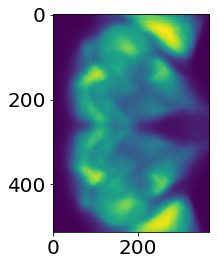

In [4]:
file = os.path.join(root_directory, '2019_nov_meanbrain', 'meanbrain_final.nii')
meanbrain = bbb.load_numpy_brain(file)
meanbrain = ants.from_numpy(meanbrain)
anatomy_xml = os.path.join(root_directory, 'fly_25', 'anat_0', 'anatomy.xml')
meanbrain.set_spacing(bbb.get_resolution(anatomy_xml))
plt.imshow(meanbrain.numpy()[:,:,150])

# Load Anatomies

In [5]:
flies = ['fly_1',
         'fly_3',
         'fly_5',
         'fly_7',
         'fly_19',
         'fly_21',
         'fly_48',
         'fly_51',
         'fly_54',
         'fly_68']

anatomy = {}

for fly in flies:
    anat_folder = os.path.join(root_directory, fly, 'anat_0')
    try:
        anatomy[fly] = bbb.load_numpy_brain(os.path.join(anat_folder, 'anatomy_channel_1.nii'))
        print('Loaded {}'.format(fly))
    except:
        print('failed to load anatomy_channel_1.nii: {}'.format(fly))
        try:
            anatomy[fly] = bbb.load_numpy_brain(os.path.join(anat_folder, 'anatomy.nii'))
        except:
            print('failed to load anatomy.nii: {}'.format(fly))


~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_1

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 494.08 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_3

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 546.29 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_5

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 397.02 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_7

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 447.31 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_19

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 546.80 ms

~~ load_numpy_brain ~~
failed to load anatomy_channel_1.nii: fly_21

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 372.68 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 309.25 ms
Loaded fly_48

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 363.03 ms
Loaded fly_51

~~ load_numpy_brain ~~
lo

In [6]:
to_rotate = ['fly_1', 'fly_7']
for k in to_rotate:
    anatomy[k] = np.swapaxes(anatomy[k],0,1)

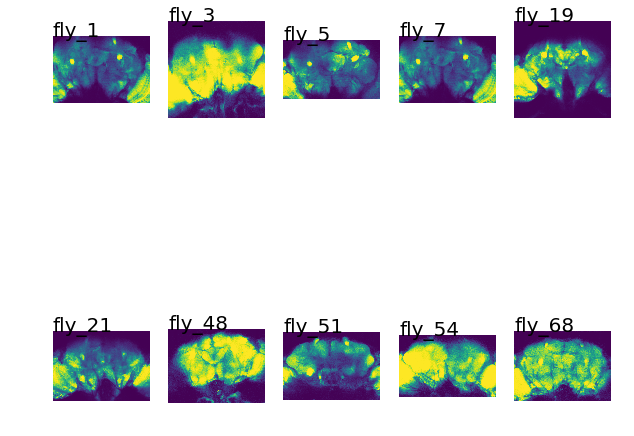

In [7]:
plt.figure(figsize=(10,10))
for i,k in enumerate(anatomy):
    plt.subplot(2,5,i+1)
    plt.imshow(anatomy[k][:,:,100].T)
    plt.axis('off')
    plt.text(0,0,k)

In [8]:
anatomy_ants = {}
for anat in anatomy:
    anatomy_xml = os.path.join(root_directory, anat, 'anat_0', 'anatomy.xml')
    anatomy_ants[anat] = ants.from_numpy(anatomy[anat])
    anatomy_ants[anat].set_spacing(bbb.get_resolution(anatomy_xml))
    print('DONE: {}'.format(anat))

DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68


# Load Transforms

In [11]:
transform_dir = os.path.join(root_directory, 'fly_48', 'anat_0', 'warp2mean_20191107')
transform_files = os.listdir(transform_dir)


#for transform in transforms:
#    file = os.path.split(transform)[-1]
#    move_to = os.path.join(root_directory, 'fly_48', 'anat_0', 'warp2mean_20191107', file)
#    shutil.copy(transform, move_to)

In [14]:
full_transform_files = [os.path.join(transform_dir, file) for file in transform_files[::-1]]

In [15]:
full_transform_files

['/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_48/anat_0/warp2mean_20191107/tmpys_l3qd11Warp.nii.gz',
 '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_48/anat_0/warp2mean_20191107/tmpys_l3qd10GenericAffine.mat']

In [16]:
warp_applied = ants.apply_transforms(meanbrain,
                                   anatomy_ants['fly_48'],
                                   full_transform_files)

In [17]:
warp_applied

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 368, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [18]:
save_file = os.path.join(root_directory, 'fly_48', 'anat_0', '20191107_quicktest_loadwarp.nii')
bbb.save_brain(save_file, warp_applied.numpy())


~~ save_brain ~~
Current memory usage: 7.23GB
save_brain done. Duration: 9.50 min


# Reconstruct spatial PCs

### Load models

In [22]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/20191106_analysis/20191106_models.json'
with open(file) as json_file:
    models = json.load(json_file)

In [53]:
for fly in flies:
    
    # Get coefs
    for model in models:
        if model['fly'] == fly and model['num_pcs'] == 500:
            coef_Y = model['coef_Y']
            coef_Z = model['coef_Z']
        
    # Load PCs    
    directory = os.path.join(root_directory, fly, 'func_0')
    file = os.path.join(directory, 'pca', 'scores_(spatial).npy')
    pca_spatial = np.load(file)
    
    # Correct shitty PC saving
    og_shape = pca_spatial.shape
    pca_spatial.shape = (og_shape[0], -1)
    pca_spatial.shape = (og_shape[0],
                         og_shape[2],
                         og_shape[1],
                         og_shape[3])
    
    # Create spatial maps
    spatial_map_Y = np.tensordot(coef_Y, pca_spatial[:500,:,:,:],axes=1)
    spatial_map_Z = np.tensordot(coef_Z, pca_spatial[:500,:,:,:],axes=1)
    
    # Save maps
    save_dir = os.path.join(directory, 'spatial_pcglm_maps')
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_file = os.path.join(save_dir, 'spatial_map_Y.nii')
    bbb.save_brain(save_file, spatial_map_Y)
    save_file = os.path.join(save_dir, 'spatial_map_Z.nii')
    bbb.save_brain(save_file, spatial_map_Z)


~~ save_brain ~~
Current memory usage: 26.91GB
save_brain done. Duration: 12.50 ms

~~ save_brain ~~
Current memory usage: 26.91GB
save_brain done. Duration: 6.79 ms

~~ save_brain ~~
Current memory usage: 26.81GB
save_brain done. Duration: 19.93 ms

~~ save_brain ~~
Current memory usage: 26.81GB
save_brain done. Duration: 10.39 ms

~~ save_brain ~~
Current memory usage: 25.33GB
save_brain done. Duration: 18.34 ms

~~ save_brain ~~
Current memory usage: 25.33GB
save_brain done. Duration: 7.38 ms

~~ save_brain ~~
Current memory usage: 26.91GB
save_brain done. Duration: 12.85 ms

~~ save_brain ~~
Current memory usage: 26.91GB
save_brain done. Duration: 11.64 ms

~~ save_brain ~~
Current memory usage: 26.25GB
save_brain done. Duration: 24.68 ms

~~ save_brain ~~
Current memory usage: 26.25GB
save_brain done. Duration: 6.15 ms

~~ save_brain ~~
Current memory usage: 25.80GB
save_brain done. Duration: 16.02 ms

~~ save_brain ~~
Current memory usage: 25.80GB
save_brain done. Duration: 11.6

# Make z-slice movie for all flies together

### Reload spatial maps

In [9]:
maps = {}
maps['Y'] = {}
maps['Z'] = {}

for fly in flies:
    directory = os.path.join(root_directory, fly, 'func_0', 'spatial_pcglm_maps')
    maps['Y'][fly] = bbb.load_numpy_brain(os.path.join(directory, 'spatial_map_Y.nii'))
    maps['Z'][fly] = bbb.load_numpy_brain(os.path.join(directory, 'spatial_map_Z.nii'))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 83.38 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 33.02 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 45.34 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 60.38 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 29.36 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 60.87 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 51.63 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 69.21 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 65.86 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 28.02 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 25.79 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 28.57 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 31.21 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 32.11 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 31.44 ms

~~ load_n

### Set ants resolution

In [10]:
behaviors = ['Y', 'Z']

In [11]:
maps_ants = {}
maps_ants['Y'] = {}
maps_ants['Z'] = {}

for fly in flies:
    metadata_file = os.path.join(root_directory, fly, 'func_0', 'imaging', 'scan.json')
    with open(metadata_file) as json_file:
        metadata = json.load(json_file)
    spacing = (metadata['x_voxel_size'], metadata['y_voxel_size'], metadata['z_voxel_size'])
    for behavior in behaviors:
        # swap x/y for some flies:
        if fly in ['fly_1', 'fly_3', 'fly_5', 'fly_7']:
            maps[behavior][fly] = np.swapaxes(maps[behavior][fly],0,1)
        maps_ants[behavior][fly] = ants.from_numpy(maps[behavior][fly])
        maps_ants[behavior][fly].set_spacing(spacing)
    print('DONE: {}'.format(fly))

DONE: fly_1
DONE: fly_3
DONE: fly_5
DONE: fly_7
DONE: fly_19
DONE: fly_21
DONE: fly_48
DONE: fly_51
DONE: fly_54
DONE: fly_68


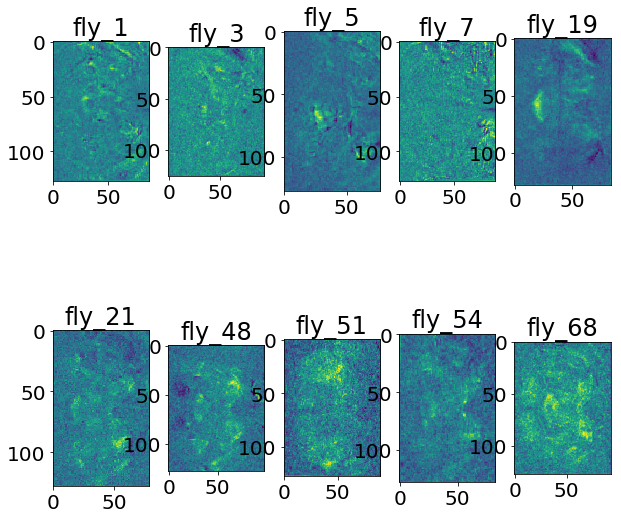

In [12]:
plt.figure(figsize=(10,10))
for i,fly in enumerate(flies):
    plt.subplot(2,5,i+1)
    plt.imshow(maps_ants['Y'][fly].numpy()[:,:,20])
    plt.title(fly)

### Need to warp to anat, then to mean

#### Load warps

In [13]:
anat2mean_transforms = {}
func2anat_transforms = {}

for fly in flies:
    
    ### anat2mean ###
    anat2mean_dir = os.path.join(root_directory, fly, 'anat_0', 'anat2mean_20191107')
    transforms = os.listdir(anat2mean_dir)
    # make sure .nii is first
    if '.nii' in transforms[-1]:
        transforms = transforms[::-1]
    anat2mean_transforms[fly] = [os.path.join(anat2mean_dir, file) for file in transforms]
        
    ### func2anat ###
    func2anat_dir = os.path.join(root_directory, fly, 'anat_0', 'func2anat_20191107')
    transforms = os.listdir(func2anat_dir)
    func2anat_transforms[fly] = [os.path.join(func2anat_dir, file) for file in transforms]

## Apply transforms to maps

In [14]:
map2mean = {}
map2mean['Y'] = {}
map2mean['Z'] = {}

for behavior in behaviors:
    for fly in flies:
        ### func2anat ###
        slave = maps_ants[behavior][fly]
        master = anatomy_ants[fly]
        transforms = func2anat_transforms[fly]
        temp = ants.apply_transforms(master,slave,transforms)

        ### anat2mean ###
        slave = temp
        master = meanbrain
        transforms = anat2mean_transforms[fly]
        map2mean[behavior][fly] = ants.apply_transforms(master,slave,transforms)

In [15]:
good_flies = ['fly_1', 'fly_3', 'fly_5', 'fly_19', 'fly_21']

In [421]:
brain_Z = []
for fly in flies:
    brain_Z.append(map2mean['Z'][fly].resample_image((3,3,3)).numpy())

In [423]:
brain_mean_Z = np.mean(np.abs(brain_Z),axis=0)

In [425]:
brain_mean_Z = np.swapaxes(brain_mean_Z,0,1)

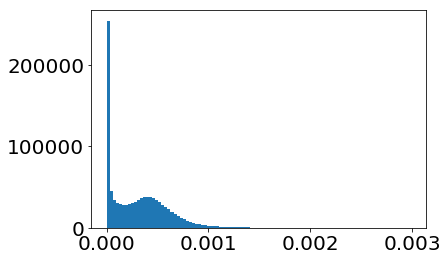

In [456]:
plt.hist(brain_mean_Z.flatten(),bins=100);

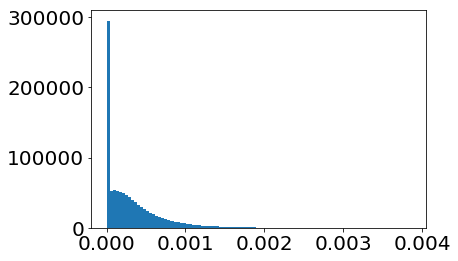

In [457]:
plt.hist(brain_mean.flatten(),bins=100);

In [448]:
brain_mean_Z *= 2

In [366]:
brain_mean = np.mean(np.abs(brain),axis=0)

In [382]:
brain_mean = np.swapaxes(brain_mean,0,1)

In [33]:
meanbrain_to_plot = meanbrain.resample_image((3,3,3)).numpy()

In [34]:
meanbrain_to_plot = np.swapaxes(meanbrain_to_plot,0,1)

In [460]:
Y_clip = brain_mean.copy()
Z_clip = brain_mean_Z.copy()

In [586]:
thresh = np.std(Y_clip) * 3
low = Y_clip > -thresh
high = Y_clip < thresh
middle = low & high
Y_clip[middle] = np.nan

thresh = np.std(Z_clip) * 3
low = Z_clip > -thresh
high = Z_clip < thresh
middle = low & high
Z_clip[middle] = np.nan

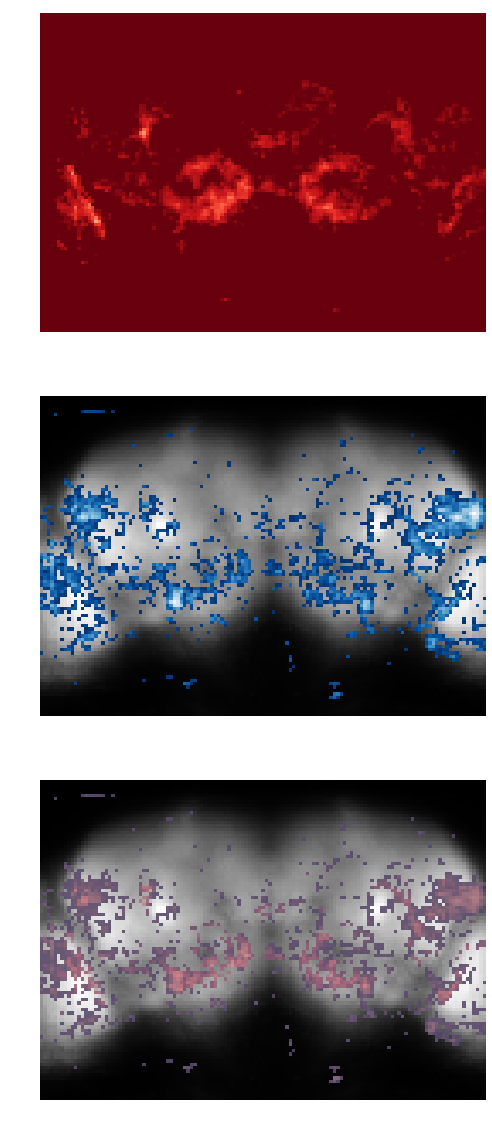

In [617]:
plt.figure(figsize=(20,20))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191107_movie_velocity_anat'
#os.mkdir(save_path)
#for i in range(47,48):
for i in range(35,36):
    
    ax_1 = plt.subplot(311)
    ax_2 = plt.subplot(312)
    ax_3 = plt.subplot(313)
    #ax.imshow(brain_mean[:,:,i].T,cmap='inferno',vmin=0,vmax=0.003)
    ax_1.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    ax_2.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    ax_3.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    
    
    #colors_1 = Normalize(0, 0.002)(Y_clip[:,:,i])
    norm = plt.Normalize()
    colors_1 = plt.cm.Reds_r(norm(Y_clip))
    #colors_1 = cmap(norm(Y_clip))
    
    #colors_1[colors_1 == 0] = np.nan
    colors_1 = plt.cm.Reds_r(plt.Normalize(np.nanmin(Y_clip),np.nanmax(Y_clip))(Y_clip))
    ax_1.imshow(colors_1[:,:,i])
    ax_2.imshow(Z_clip[:,:,i],cmap='Blues_r')
    
    
    colors_3 = (colors_1[:,:,i] + colors_2[:,:,i])/2
    ax_3.imshow(colors_3,alpha=1)
    #ax_3.imshow(colors_1[:,:,i],alpha=1)
    #ax_3.imshow(colors_1[:,:,i],alpha=1)

    
    ax_1.axis('off')
    ax_2.axis('off')
    ax_3.axis('off')
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    #plt.savefig(fname,dpi=100,bbox_inches='tight')

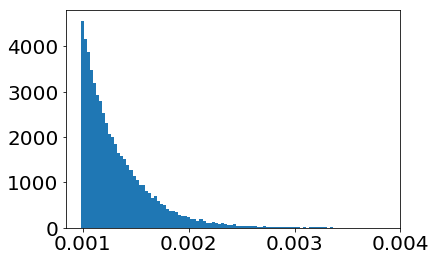

In [608]:
plt.hist(Y_clip.flatten(),bins=100);

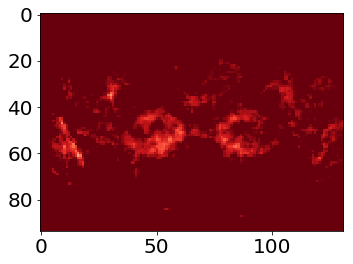

In [620]:
colors_1 = plt.cm.Reds_r(plt.Normalize(np.nanmin(Y_clip),np.nanmax(Y_clip))(Y_clip))
plt.imshow(colors_1[:,:,35])

In [626]:
test = plt.Normalize(np.nanmin(Y_clip),np.nanmax(Y_clip))(Y_clip)[:,:,35]
alphas = Normalize(0, important_number, clip=True)(Y_clip)
alphas = np.clip(alphas, 0, 1)
test[..., -1] = alphas

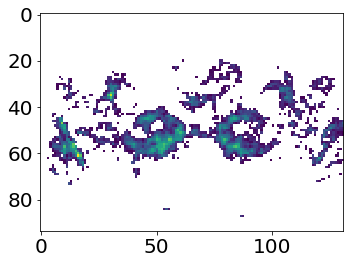

In [630]:
plt.imshow(Y_clip[:,:,35])

In [161]:
to_plot_Z = np.swapaxes(to_plot_Z,0,1)
to_plot_Y = np.swapaxes(to_plot_Y,0,1)

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83


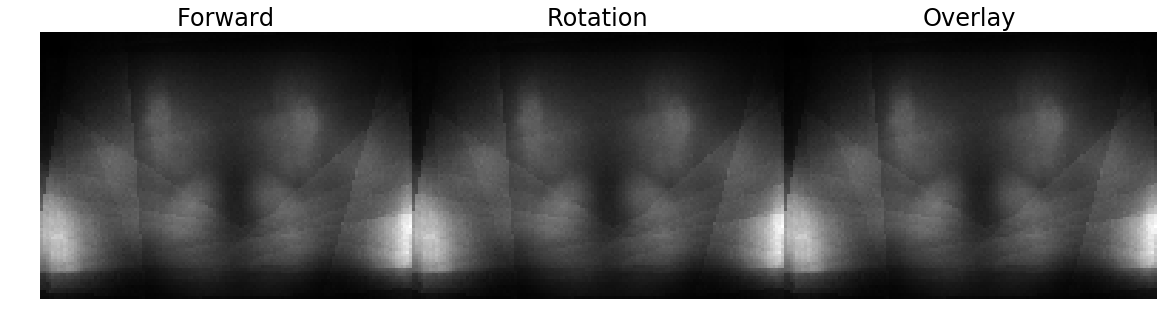

In [173]:
plt.figure(figsize=(20,10))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191110_red_blue_maps_overlay'
#os.mkdir(save_path)
#for i in range(47,48):
for i in range(15,84):
    print(i)
    
    ax_1 = plt.subplot(131)
    ax_3 = plt.subplot(133)
    ax_2 = plt.subplot(132)
    #ax.imshow(brain_mean[:,:,i].T,cmap='inferno',vmin=0,vmax=0.003)
    ax_1.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    ax_2.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    ax_3.imshow(meanbrain_to_plot[:,:,i],cmap='gray')
    
    
    # Create an alpha channel based on weight values
    # Any value whose absolute value is > value will have zero transparency
    important_number = .001 # This value really changes how alpha channel overlay looks
    alphas = Normalize(0, important_number, clip=True)(to_plot_Y)
    alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors_1 = Normalize(0, 0.003)(to_plot_Y)
    cmap = plt.cm.Reds_r
    colors_1 = cmap(colors_1)
    # Now set the alpha channel to the one we created above
    colors_1[..., -1] = alphas
    
    
    # Create an alpha channel based on weight values
    # Any value whose absolute value is > value will have zero transparency
    important_number = .001 # This value really changes how alpha channel overlay looks
    alphas = Normalize(0, important_number, clip=True)(to_plot_Z)
    alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
    # Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
    colors_2 = Normalize(0, 0.003)(to_plot_Z)
    cmap = plt.cm.Blues_r
    colors_2 = cmap(colors_2)
    # Now set the alpha channel to the one we created above
    colors_2[..., -1] = alphas
    
    
    #np.nan_to_num(colors_1, 0)
    #np.nan_to_num(colors_2, 0)
    
    where_nans = np.isnan(colors_1[:,:,:,-1])
    colors_1[where_nans] = 0
    
    where_nans = np.isnan(colors_2[:,:,:,-1])
    colors_2[where_nans] = 0
    
    ax_1.imshow(colors_1[:,:,i],alpha=1)
    ax_2.imshow(colors_2[:,:,i],alpha=1)
    
    #color is shape [:,:,:,4]
    #colors_1[colors_1 == np.nan] = 0
    #colors_3 = (colors_1[:,:,i] + colors_2[:,:,i])/2
    #colors_3[:,:,3] = 1
    #ax_3.imshow(colors_3*2,alpha=1)
    ax_3.imshow(colors_1[:,:,i],alpha=.7)
    ax_3.imshow(colors_2[:,:,i],alpha=.7)
    #ax_3.imshow(colors_1[:,:,i],alpha=1)

    
    ax_1.axis('off')
    ax_2.axis('off')
    ax_3.axis('off')
    
    ax_1.set_title('Forward')
    ax_2.set_title('Rotation')
    ax_3.set_title('Overlay')
    plt.subplots_adjust(wspace=0, hspace=0)
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')

In [704]:
test = colors_1[:,:,:,:-1]

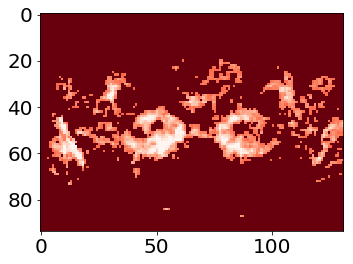

In [705]:
plt.imshow(test[:,:,35])

In [709]:
where_nans = np.isnan(colors_1[:,:,:,-1])
colors_1[where_nans] = 0
# where alpha is nan, set the others to 0

In [707]:
where_nans.shape

(94, 131, 84)

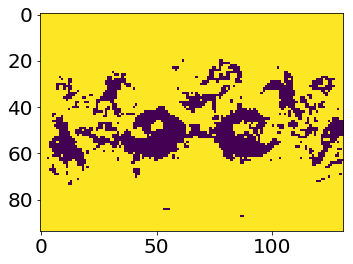

In [703]:
plt.imshow(out[:,:,35])

In [569]:
out.shape

(94, 131, 4)

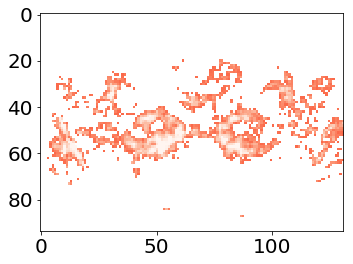

In [578]:
plt.imshow(colors_1[:,:,35,:])

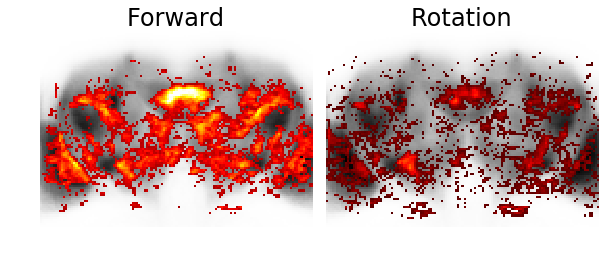

In [156]:
plt.figure(figsize=(10,10))
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191110_movie_mean'
#os.mkdir(save_path)
for i in range(41,42):
    ax1 = plt.subplot(121)
    ax1.imshow(meanbrain_to_plot[:,:,i], cmap='Greys')
    filtered = to_plot_Y[:,:,i]
    filtered[filtered == 0] = np.nan
    ax1.imshow(filtered.T,cmap='hot',vmin=0,vmax=0.003)
    ax1.axis('off')
    ax1.set_title('Forward')
    
    ax2 = plt.subplot(122)
    ax2.imshow(meanbrain_to_plot[:,:,i], cmap='Greys')
    
    filtered = ndimage.median_filter(to_plot_Z[:,:,i],size=1)
    filtered[filtered == 0] = np.nan
    ax2.imshow(filtered.T,cmap='hot',vmin=0,vmax=0.003)
    ax2.axis('off')
    ax2.set_title('Rotation')
    plt.subplots_adjust(wspace=0.05, hspace=0)

    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    #plt.savefig(fname,dpi=100,bbox_inches='tight')

In [354]:
mean_all_Z.shape

(131, 94, 84)

In [16]:
map2mean['Z']['fly_1']

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (512, 368, 251)
	 Spacing    : (0.768, 0.768, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [30]:
to_plot = {}
to_plot['Y'] = {}
to_plot['Z'] = {}

for behavior in ['Y', 'Z']:
    for fly in good_flies:
        print('Behavior: {} | Fly: {}'.format(behavior, fly))
        to_plot[behavior][fly] = map2mean[behavior][fly].resample_image((3,3,3)).numpy()
        to_plot[behavior][fly] = np.abs(to_plot[behavior][fly])
        thresh = np.std(to_plot[behavior][fly]) * 2
        low = to_plot[behavior][fly] > -thresh
        high = to_plot[behavior][fly] < thresh
        middle = low & high
        to_plot[behavior][fly][middle] = np.nan

Behavior: Y | Fly: fly_1
Behavior: Y | Fly: fly_3
Behavior: Y | Fly: fly_5
Behavior: Y | Fly: fly_19
Behavior: Y | Fly: fly_21
Behavior: Z | Fly: fly_1
Behavior: Z | Fly: fly_3
Behavior: Z | Fly: fly_5
Behavior: Z | Fly: fly_19
Behavior: Z | Fly: fly_21


In [115]:
brain_map_mean = []
for fly in good_flies:
    brain_map_mean.append(map2mean['Z'][fly].resample_image((3,3,3)).numpy())

In [116]:
brain_map_mean_Z = np.mean(np.abs(brain_map_mean),axis=0)

In [128]:
to_plot_Z = np.copy(brain_map_mean_Z)
thresh = np.std(to_plot_Z) * 2
low = to_plot_Z > -thresh
high = to_plot_Z < thresh
middle = low & high
to_plot_Z[middle] = 0


to_plot_Y = np.copy(brain_map_mean_Y)
thresh = np.std(to_plot_Y) * 2
low = to_plot_Y > -thresh
high = to_plot_Y < thresh
middle = low & high
to_plot_Y[middle] = 0


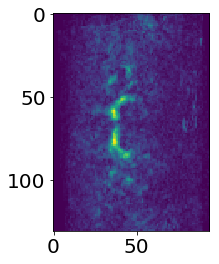

In [114]:
plt.imshow(brain_map_mean_Y[:,:,30])

15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
58.66165637969971


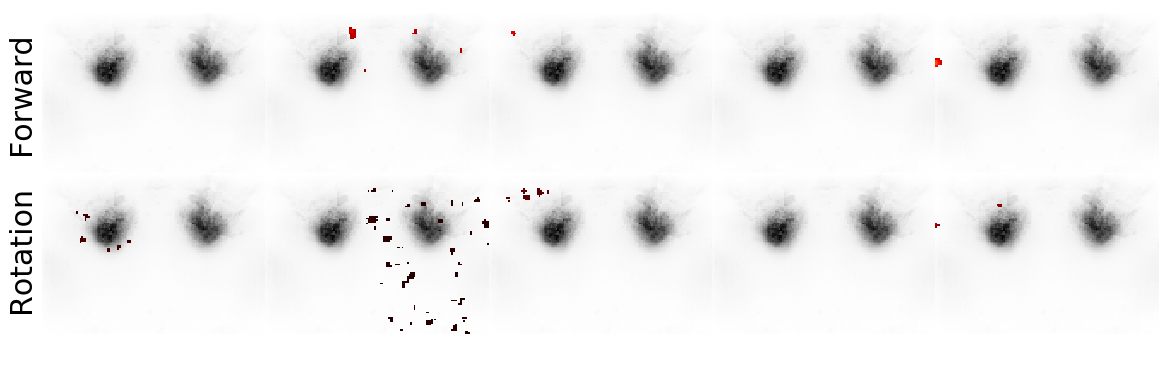

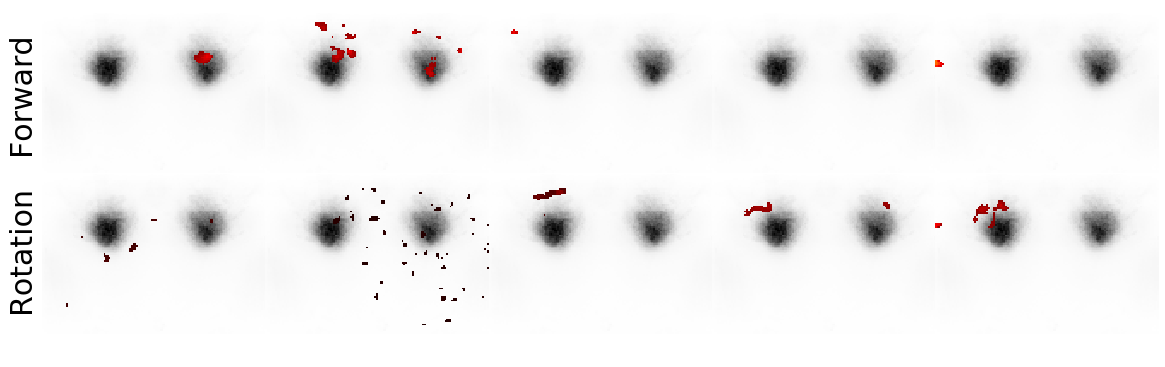

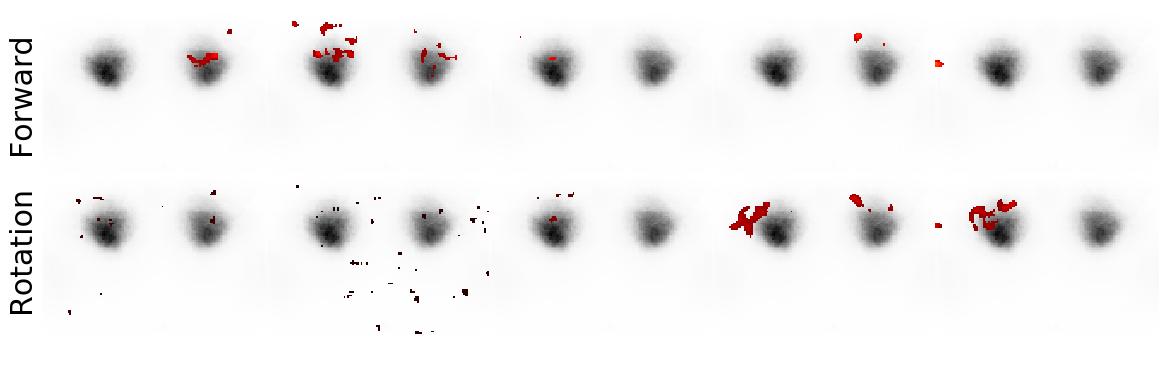

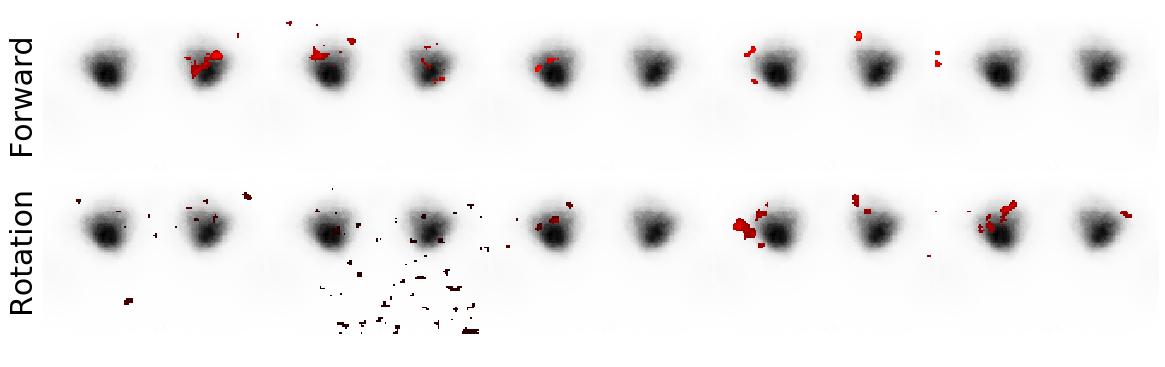

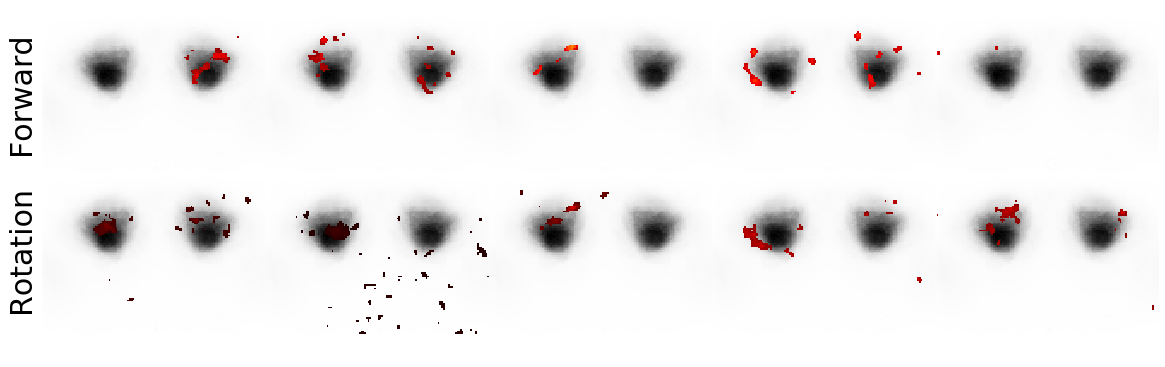

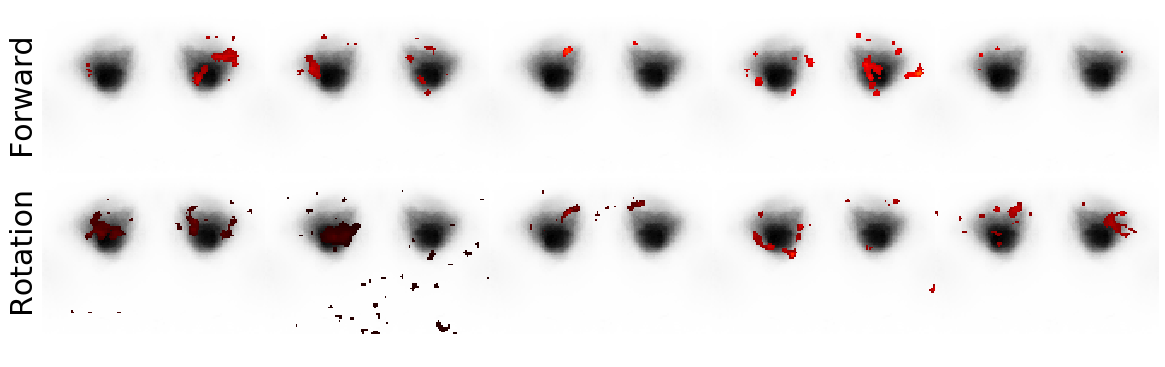

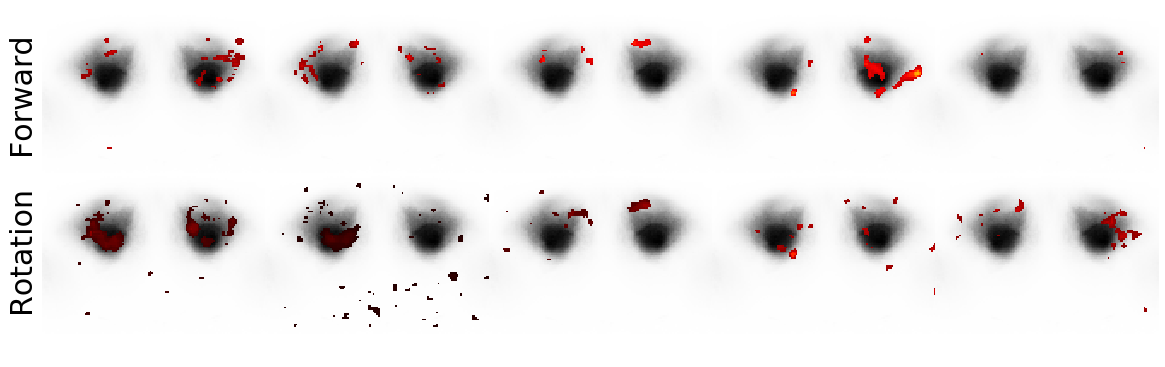

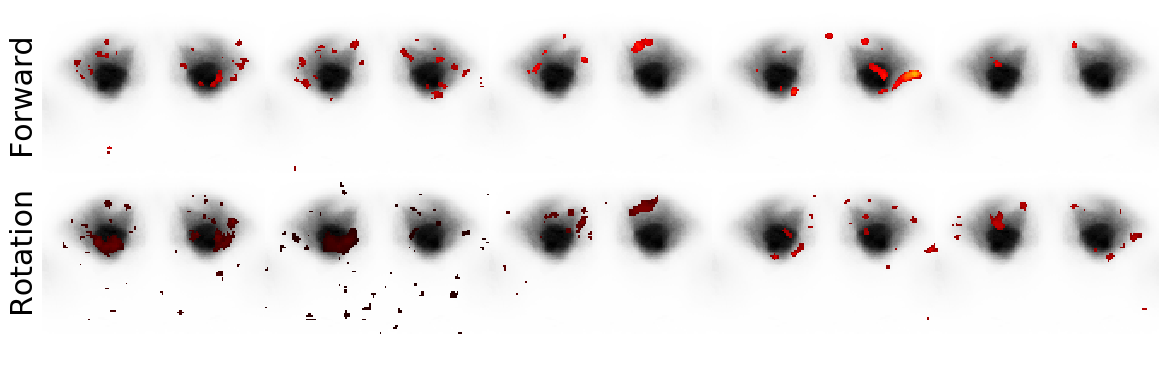

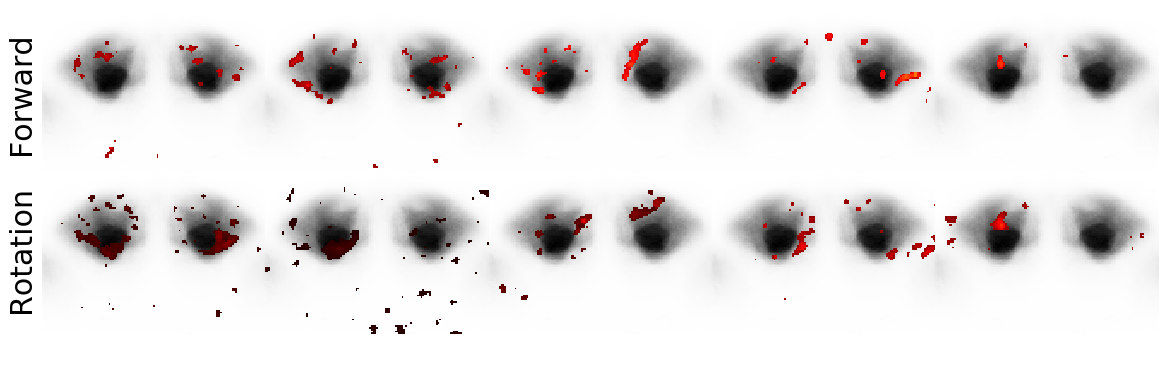

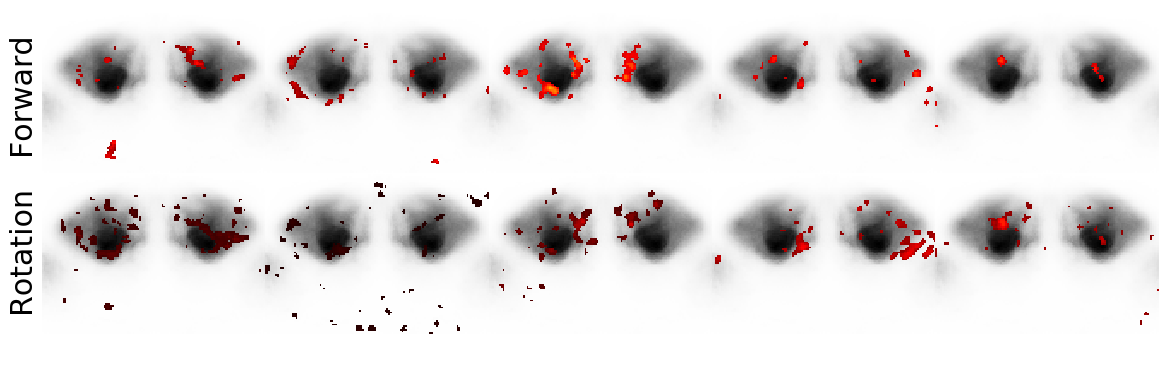

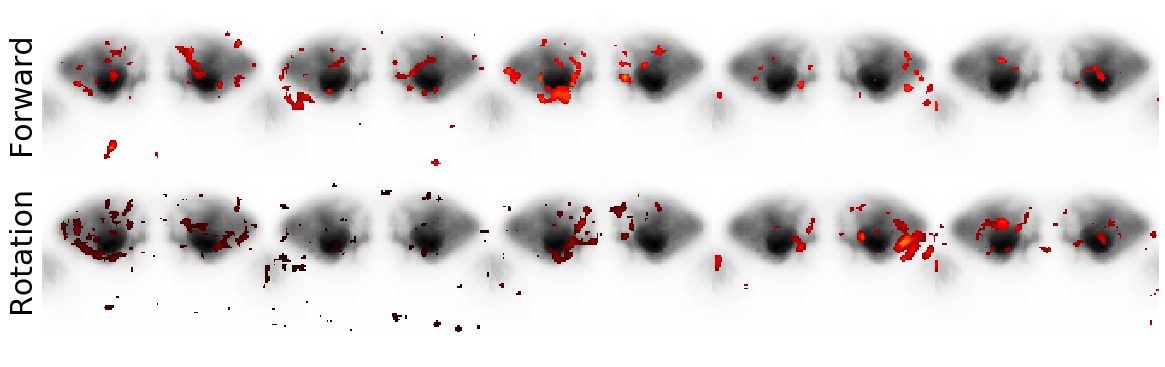

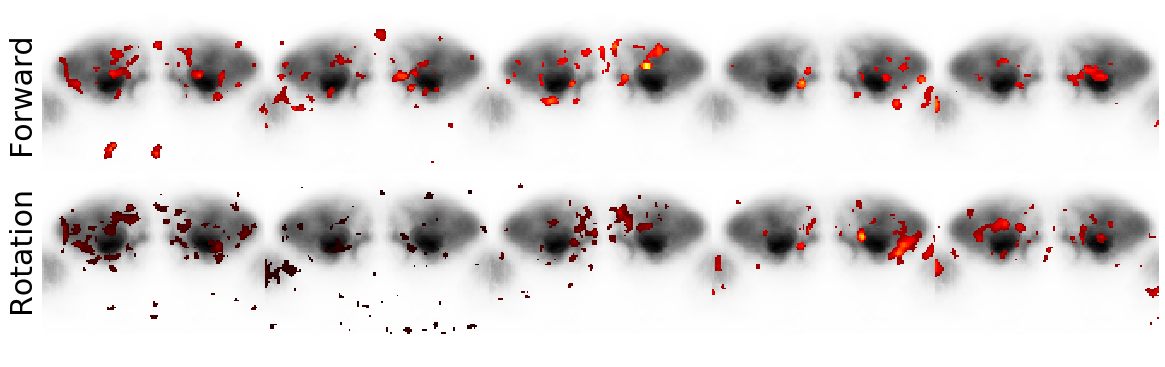

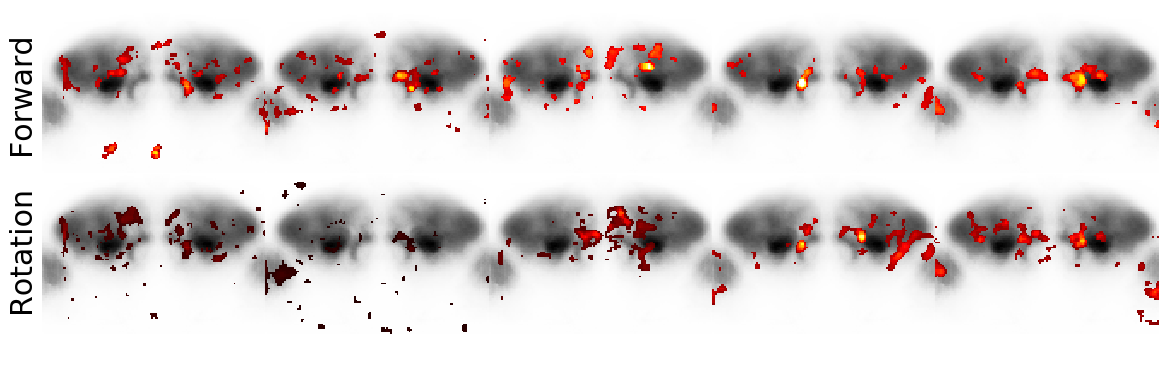

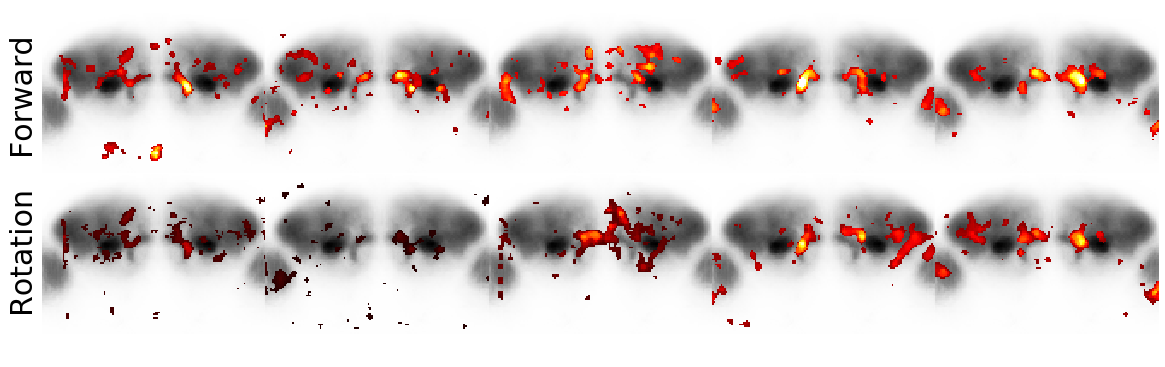

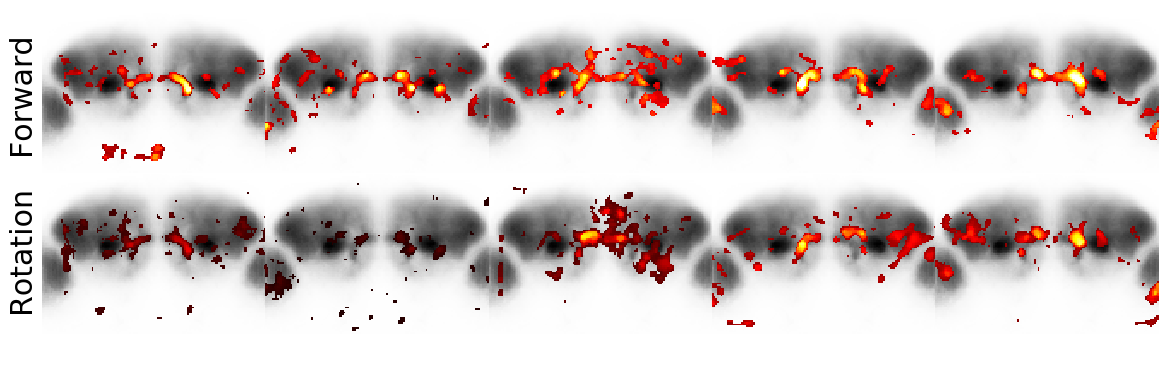

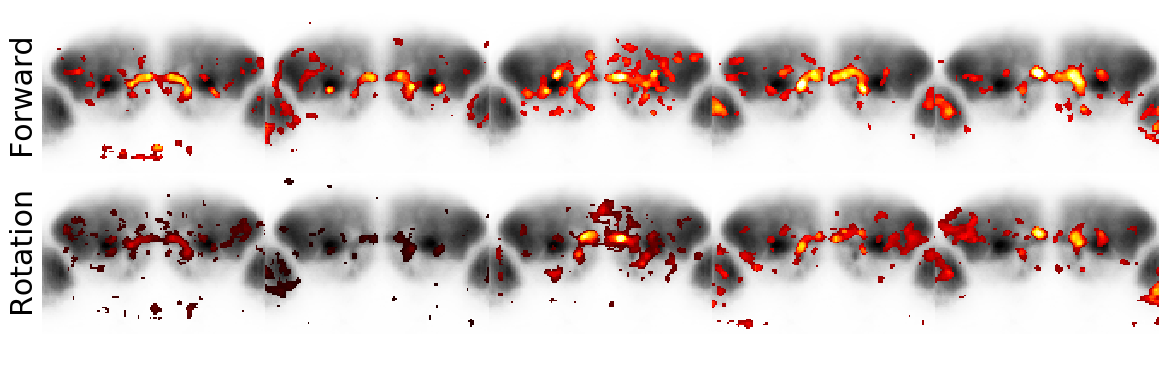

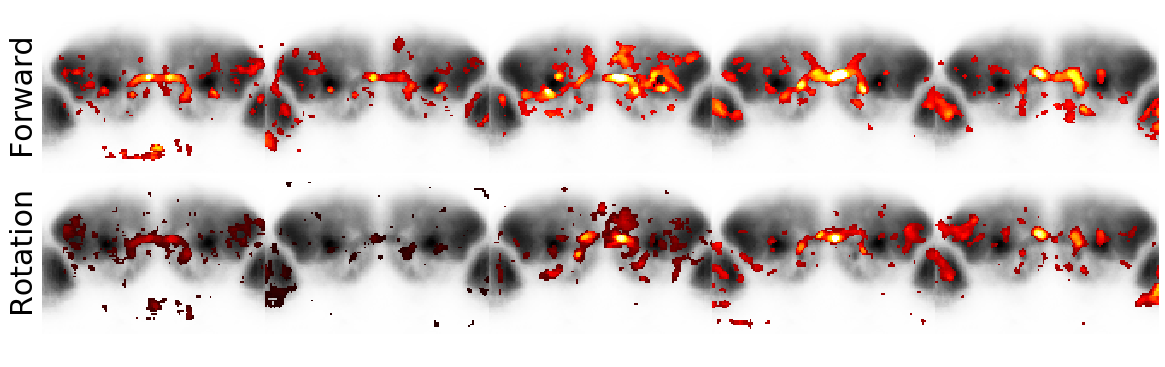

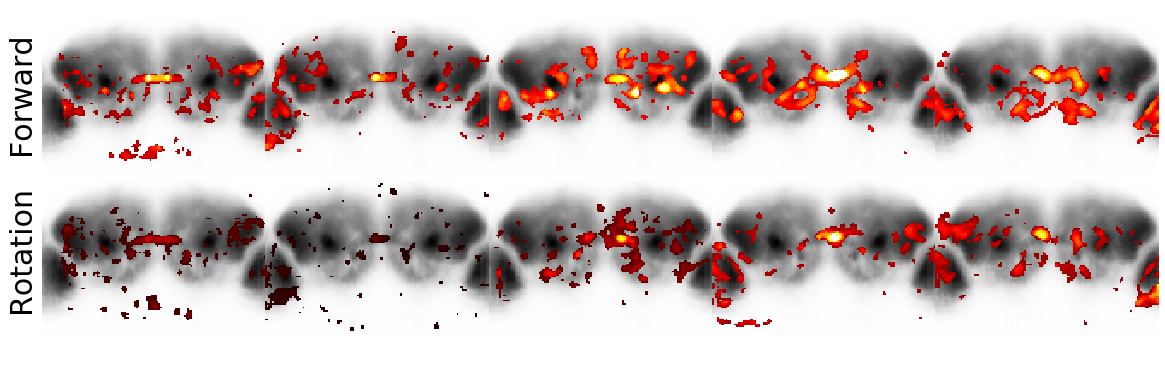

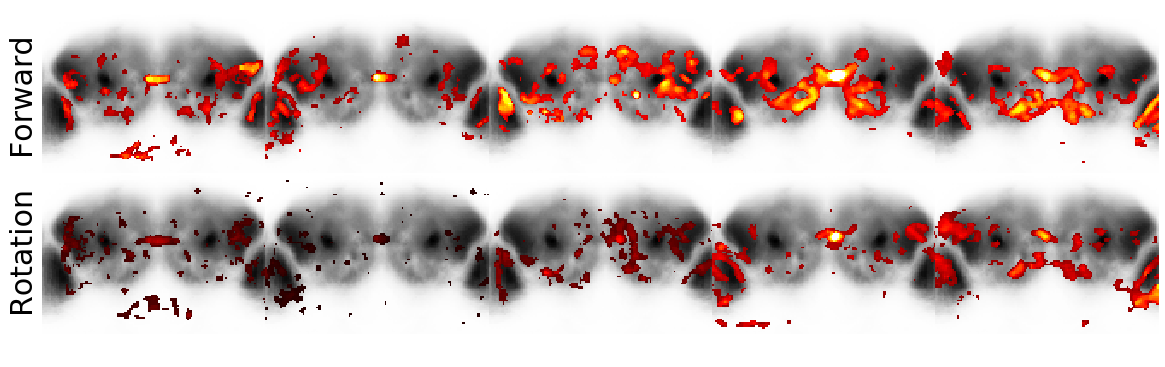

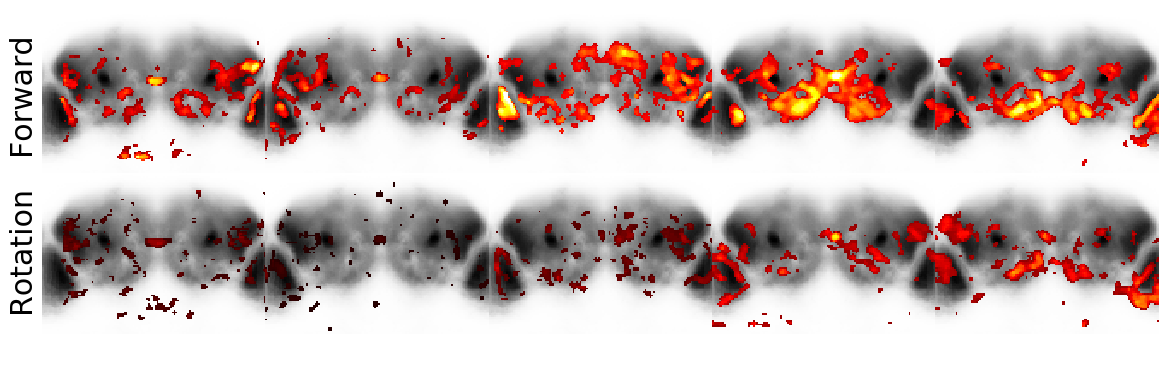

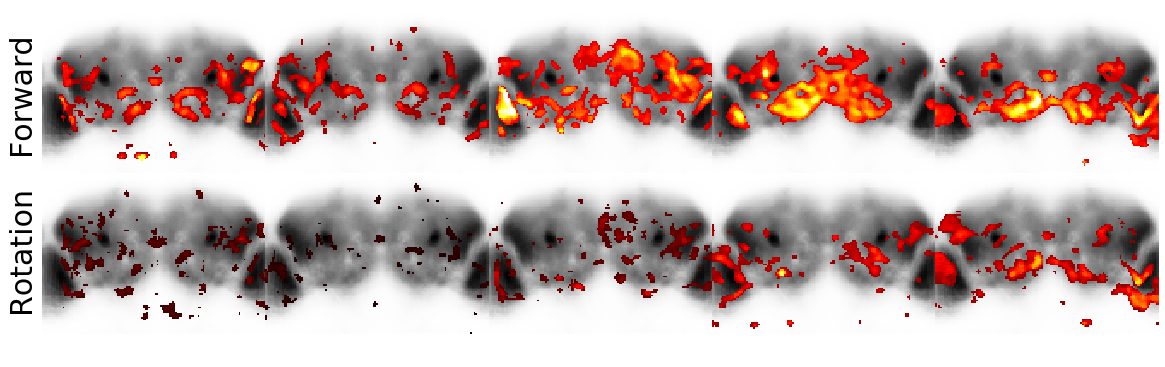

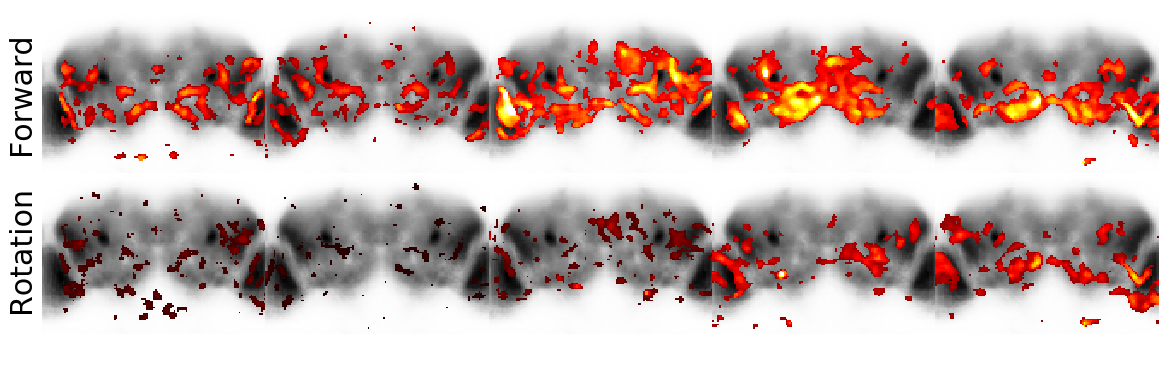

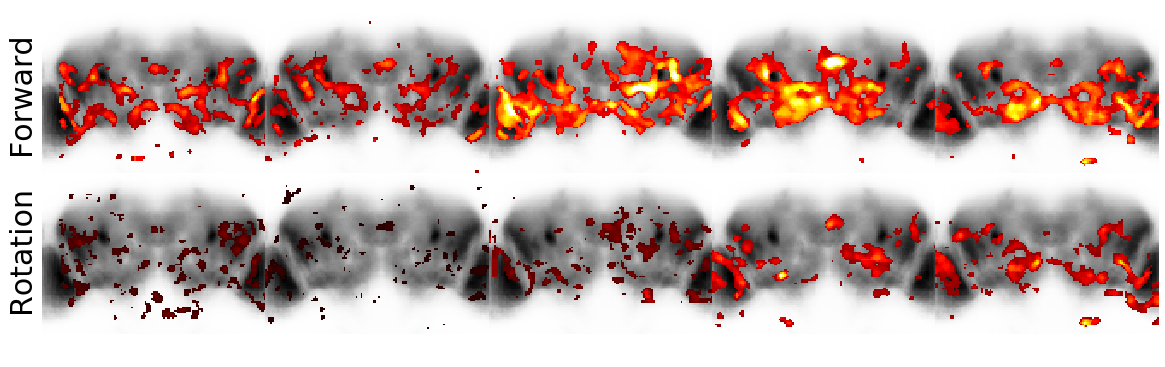

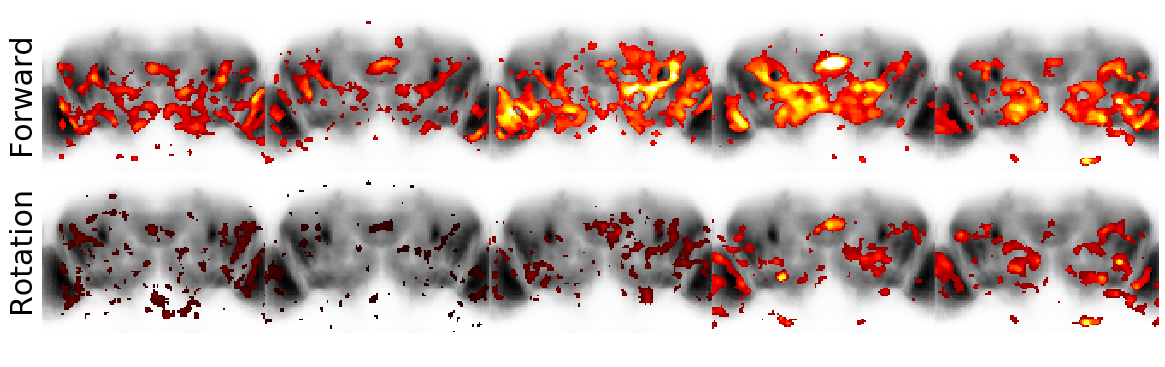

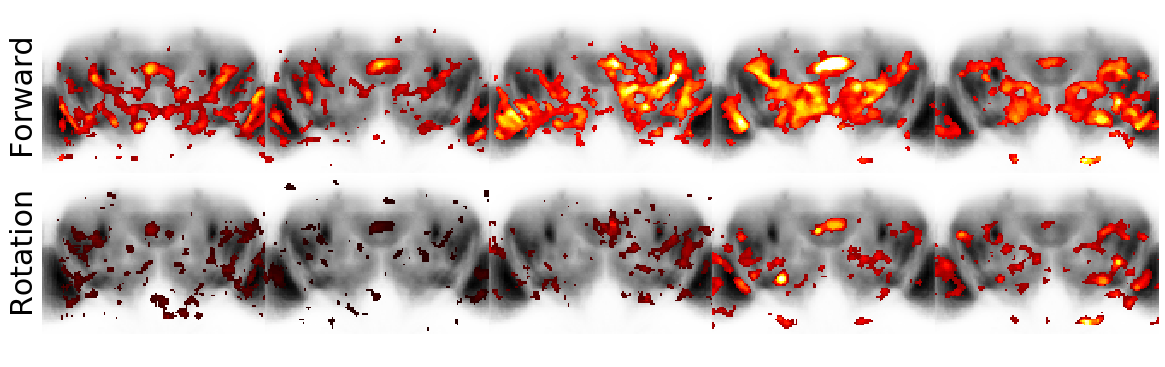

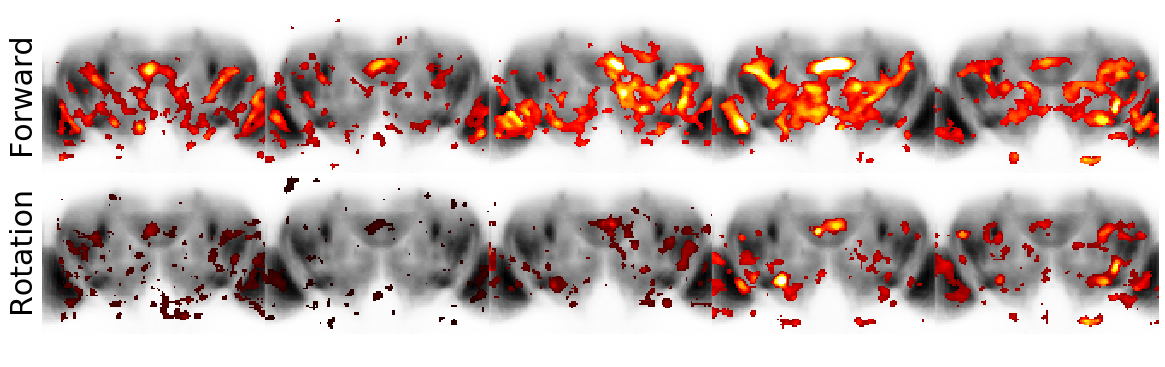

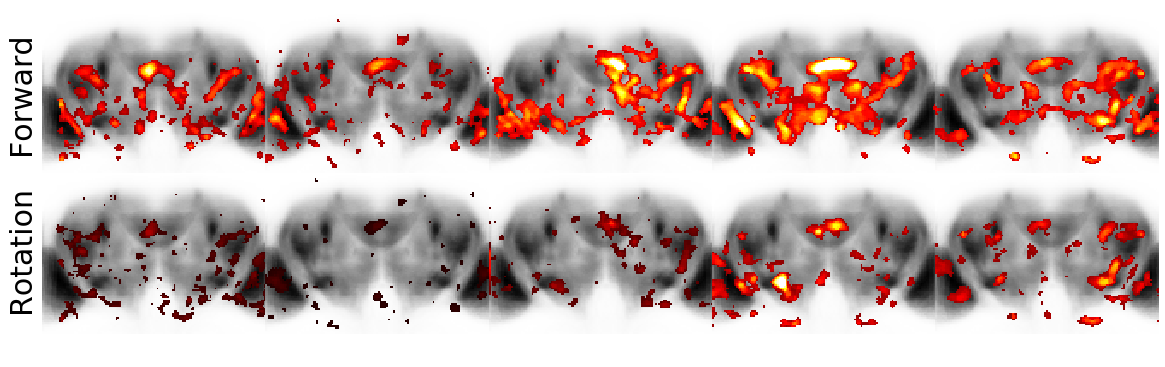

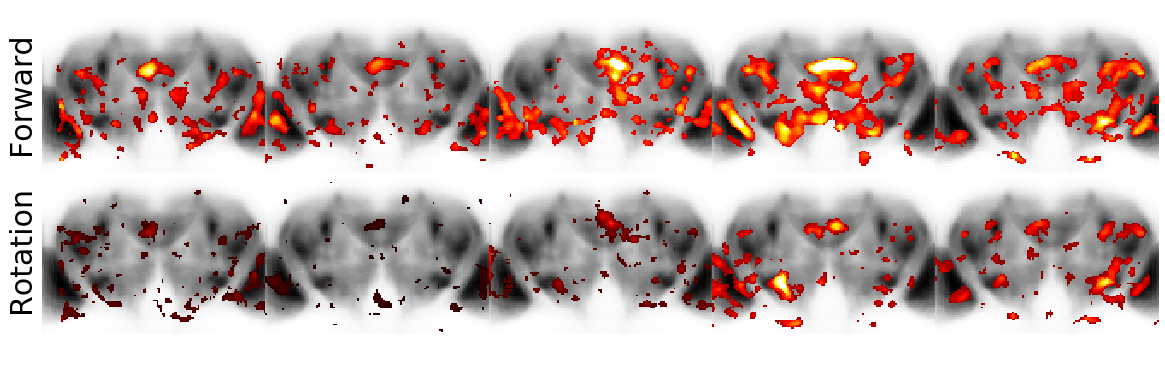

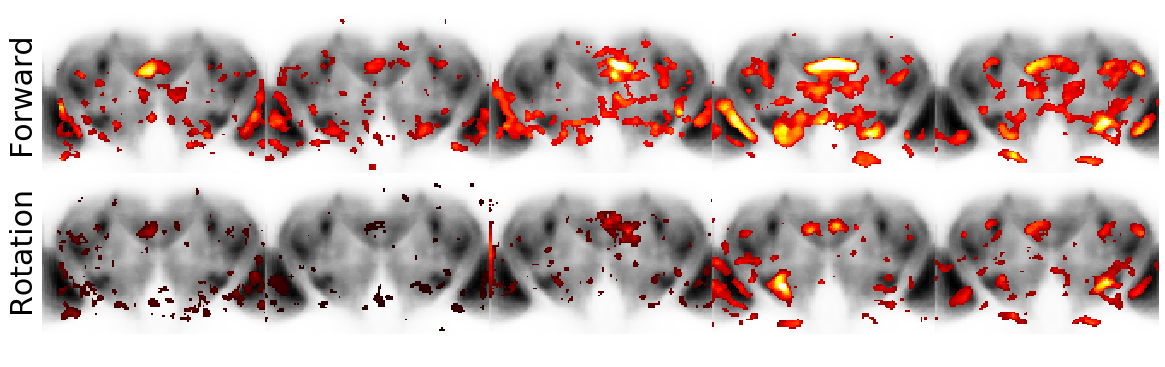

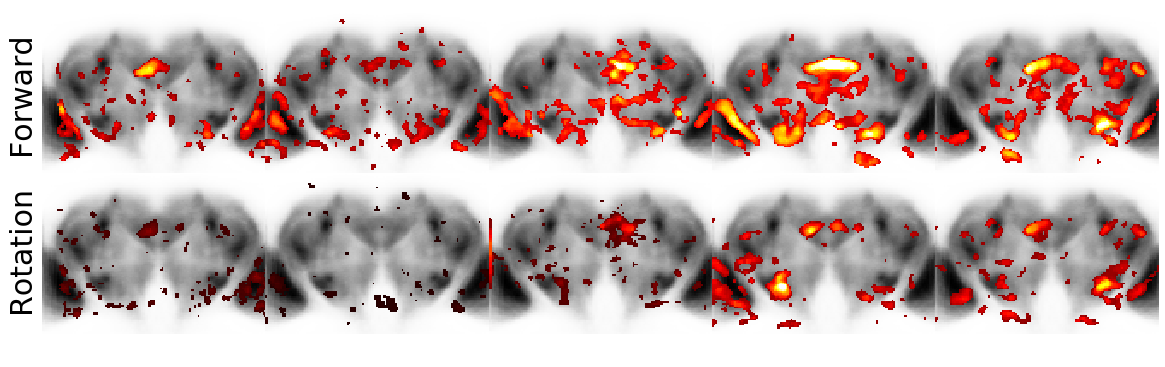

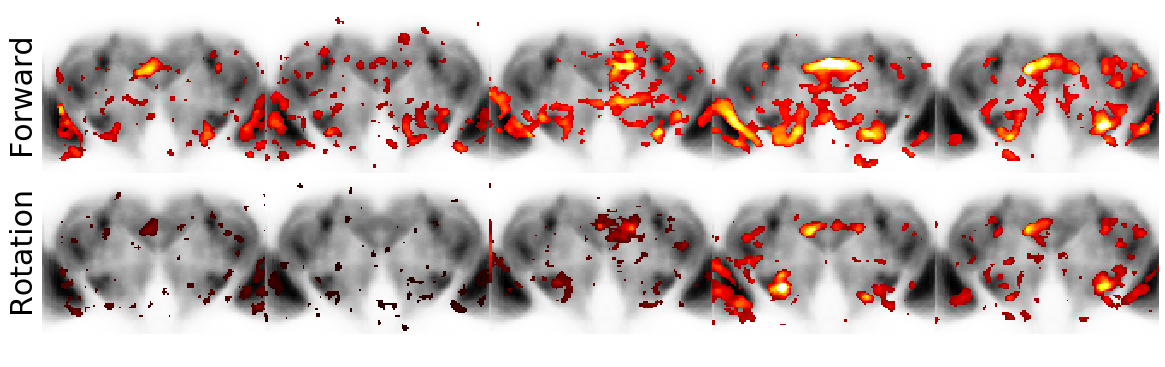

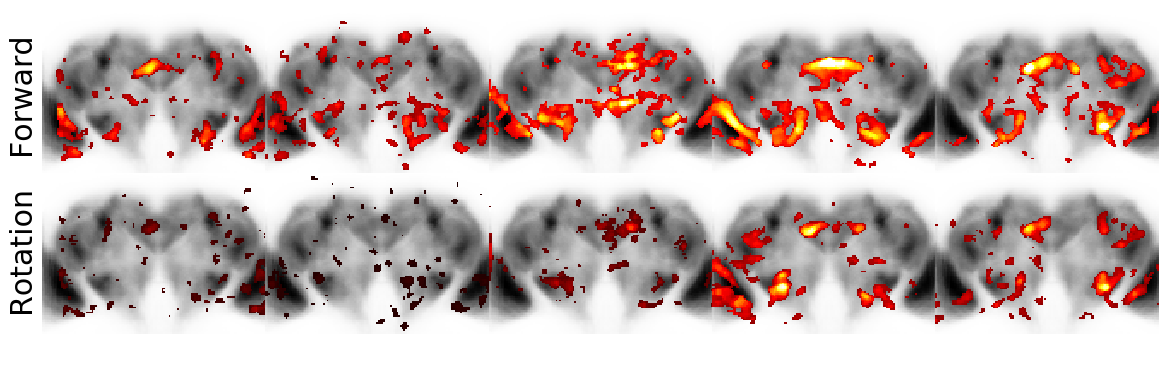

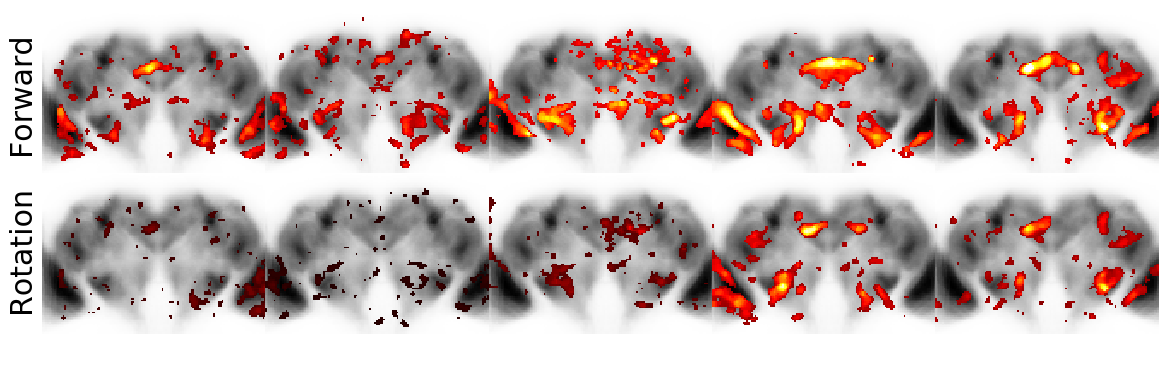

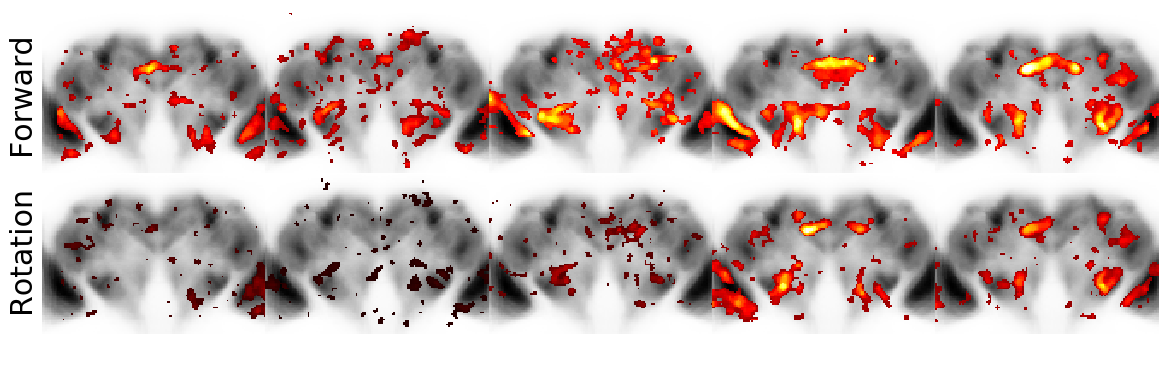

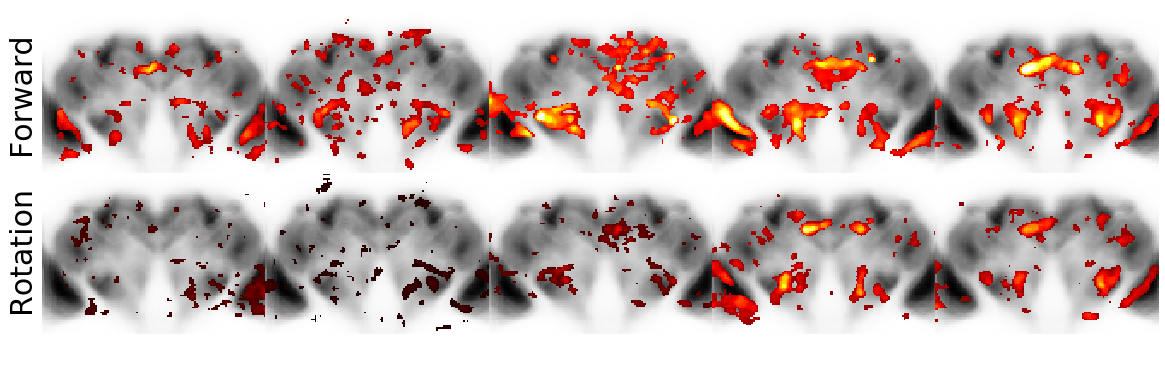

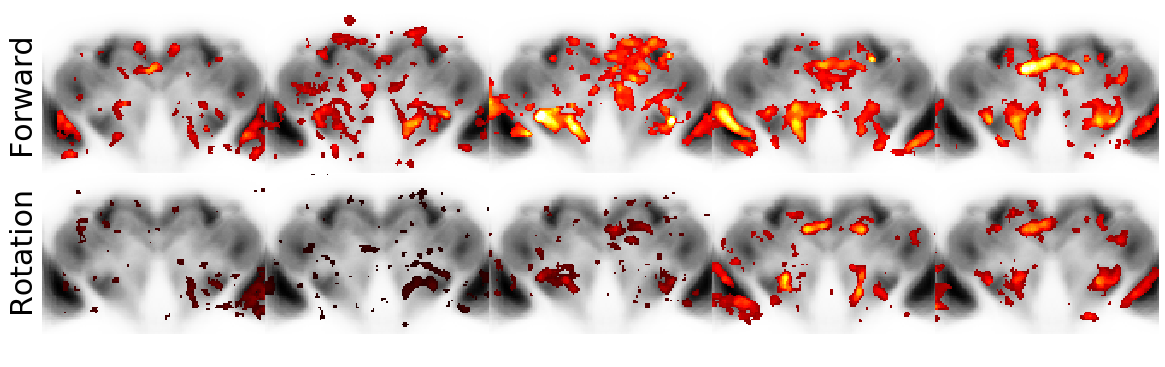

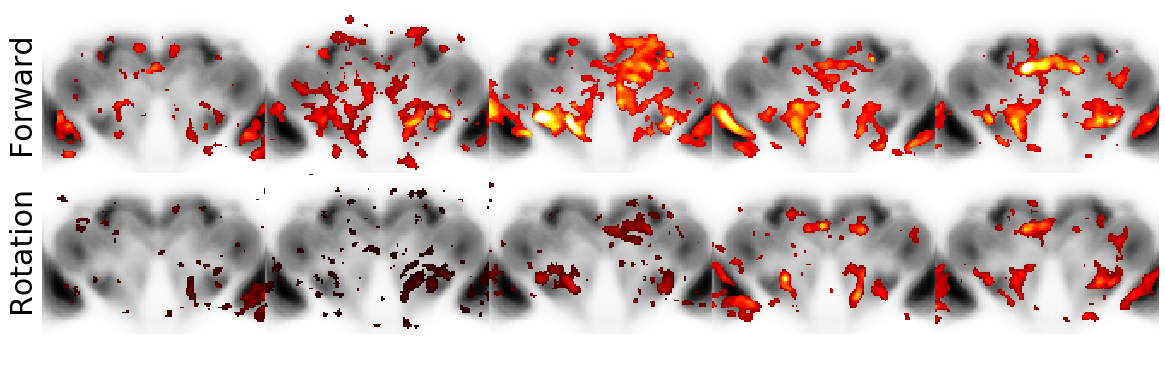

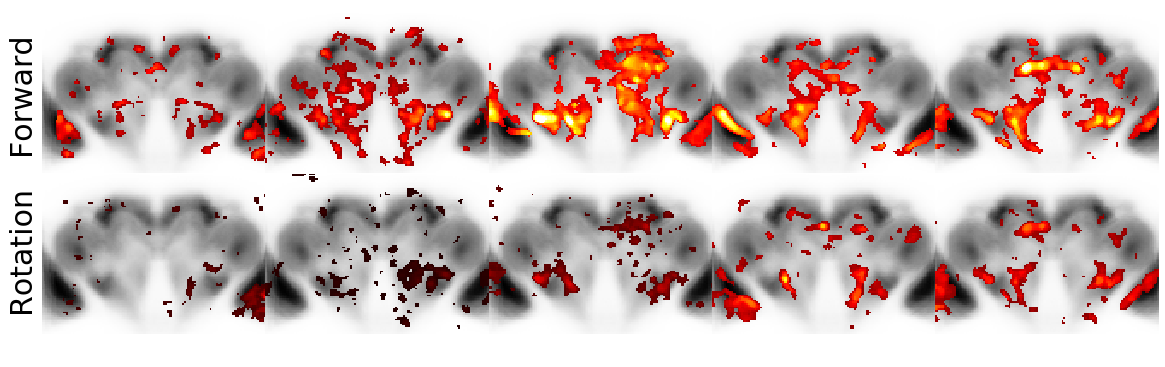

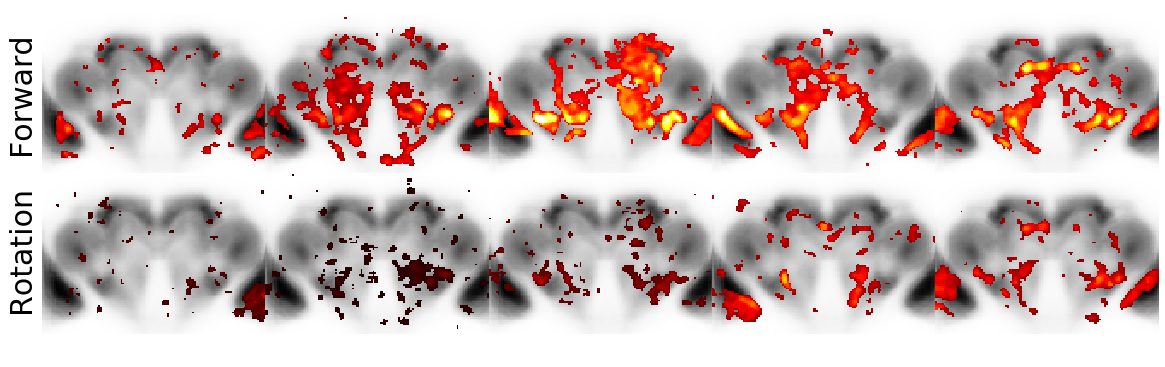

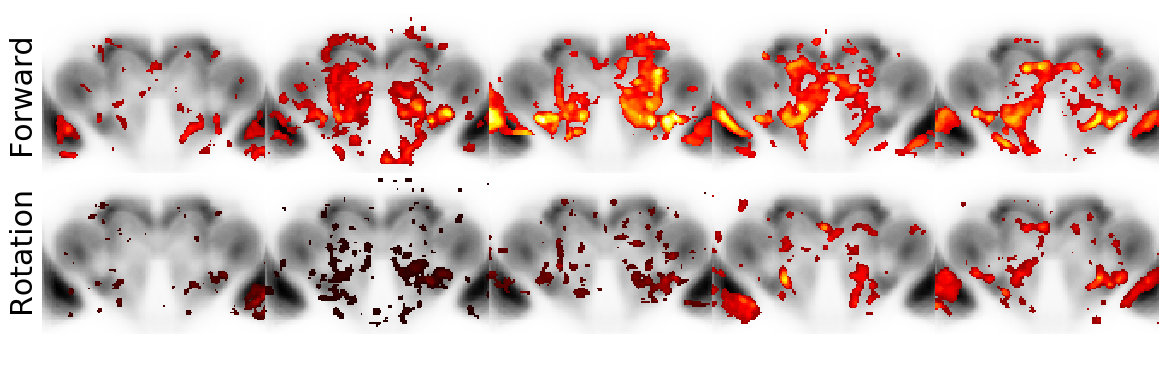

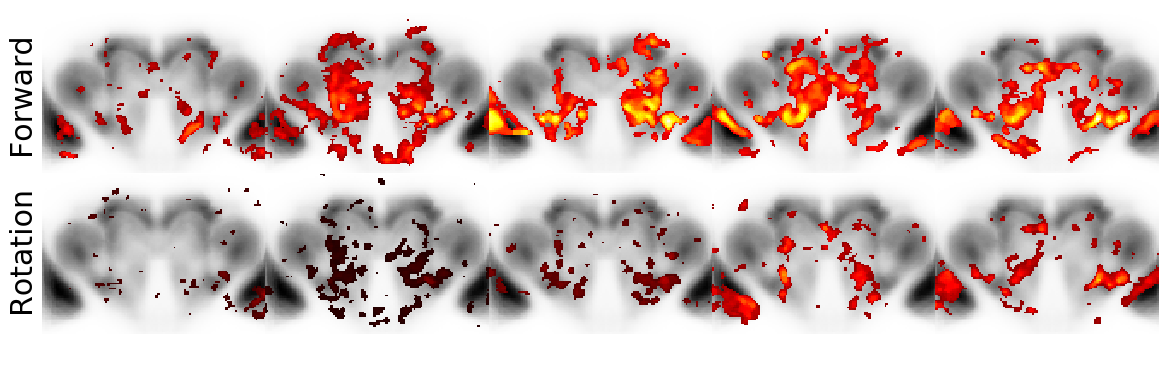

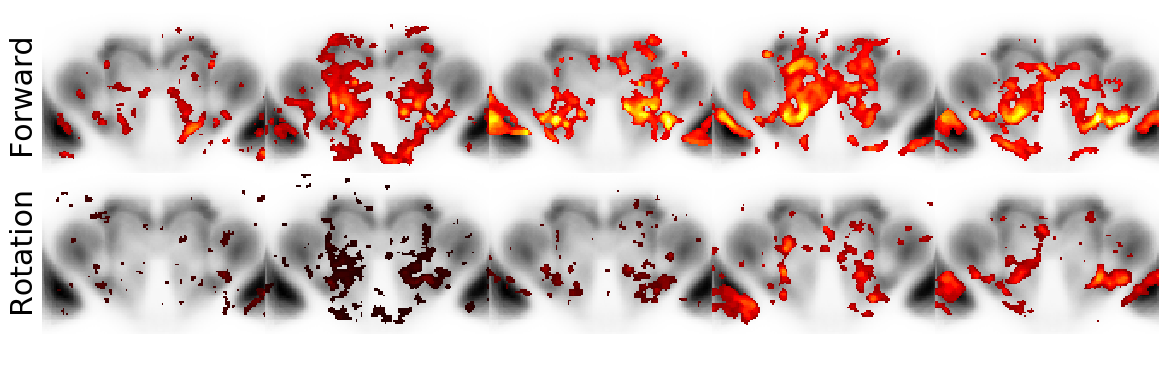

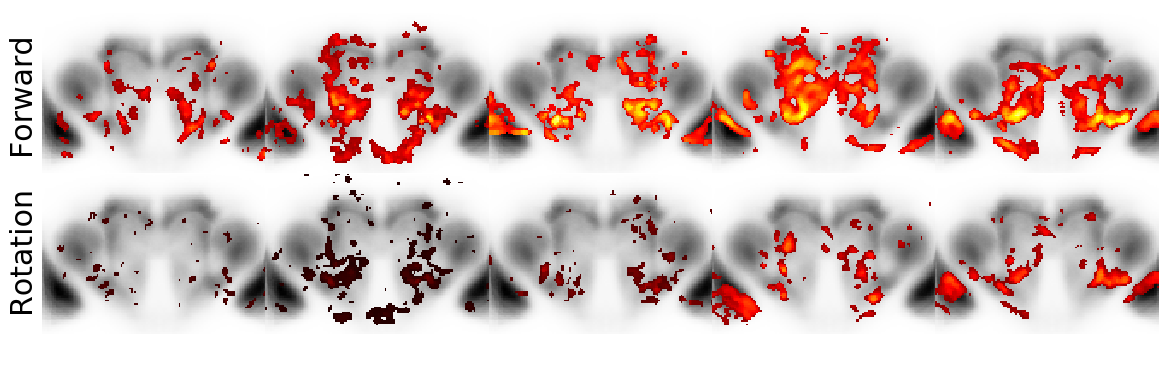

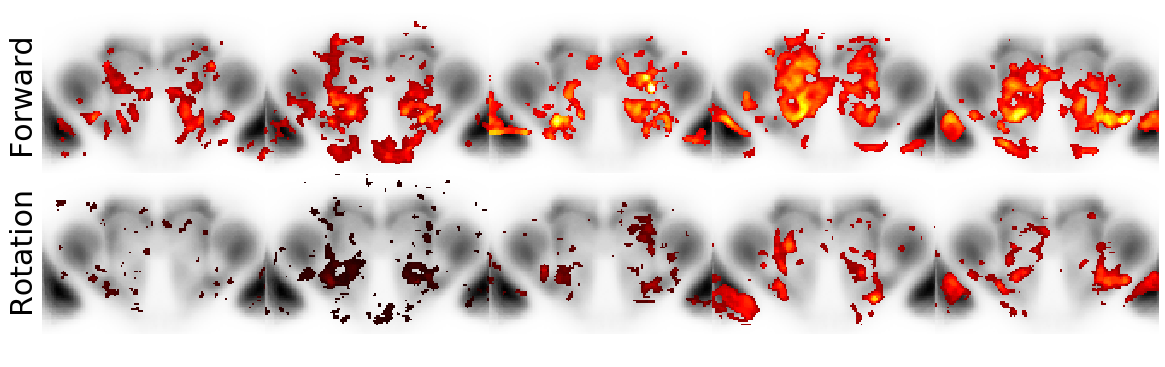

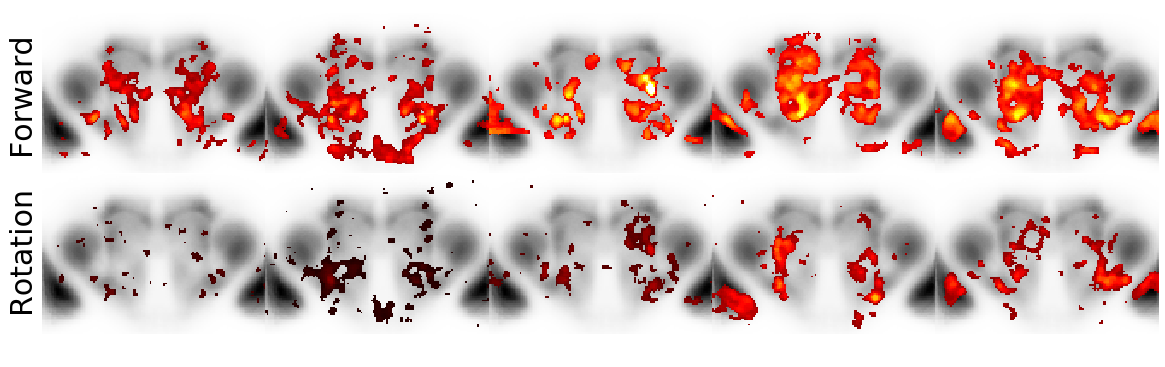

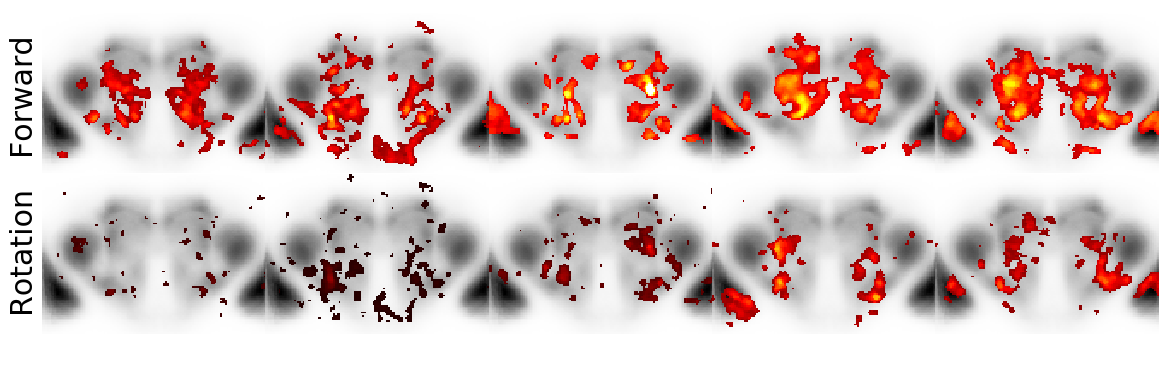

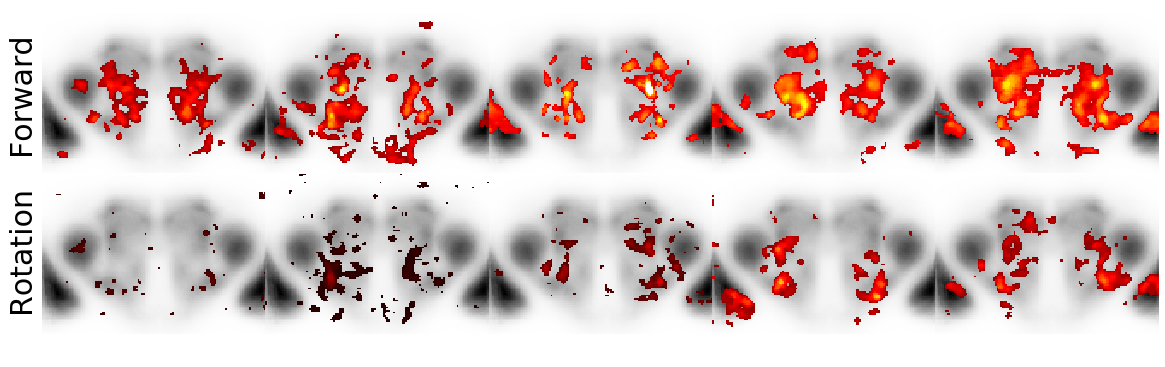

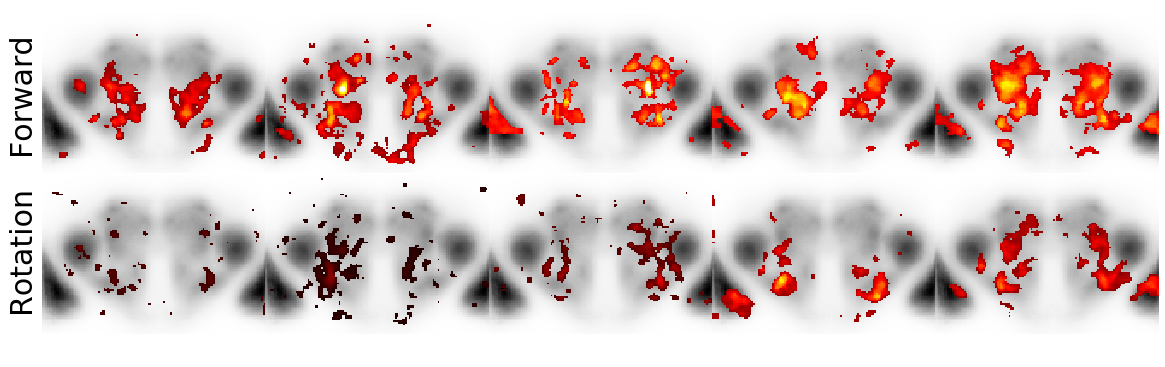

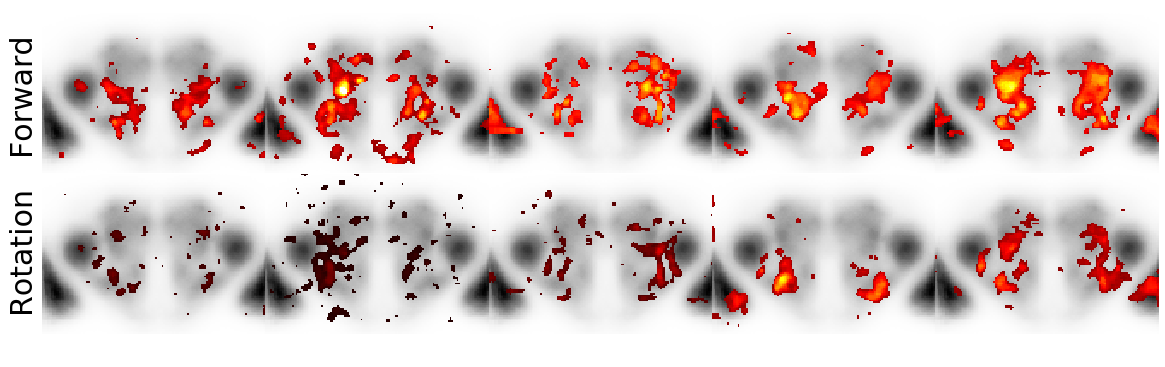

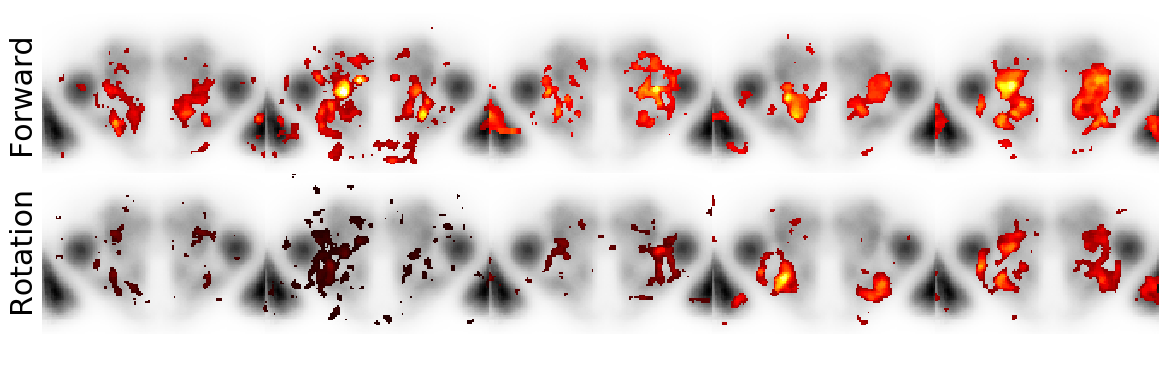

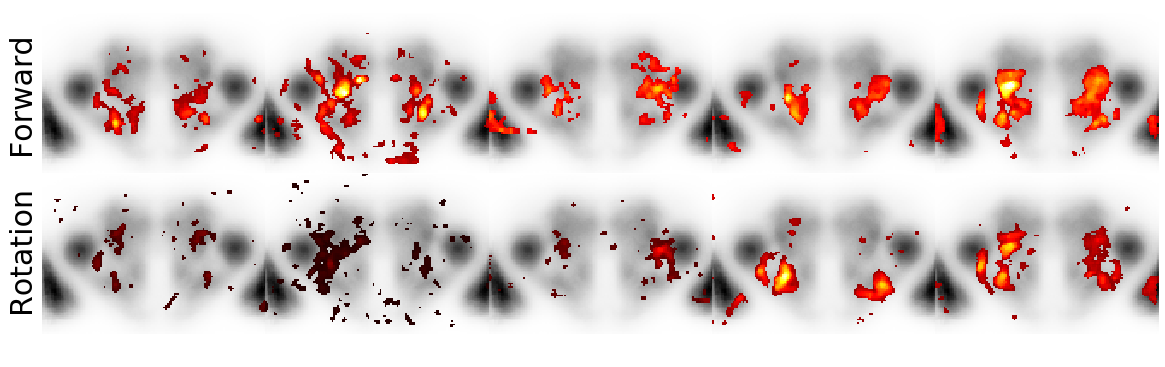

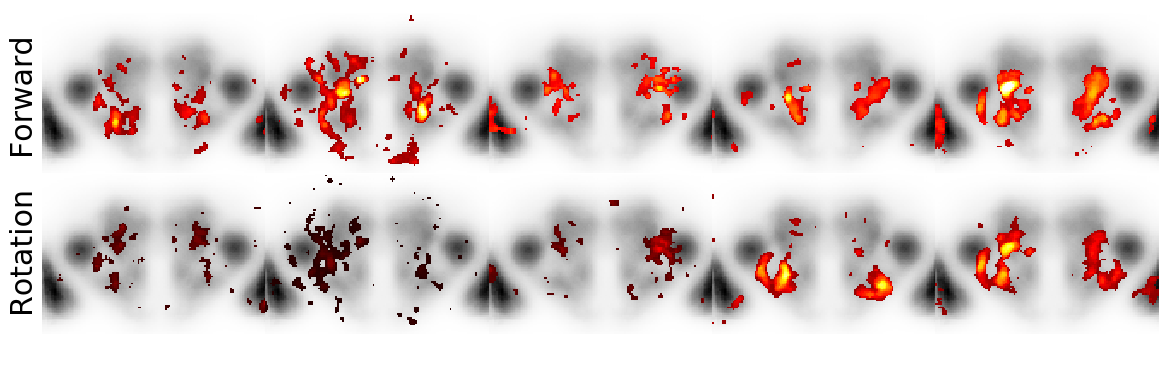

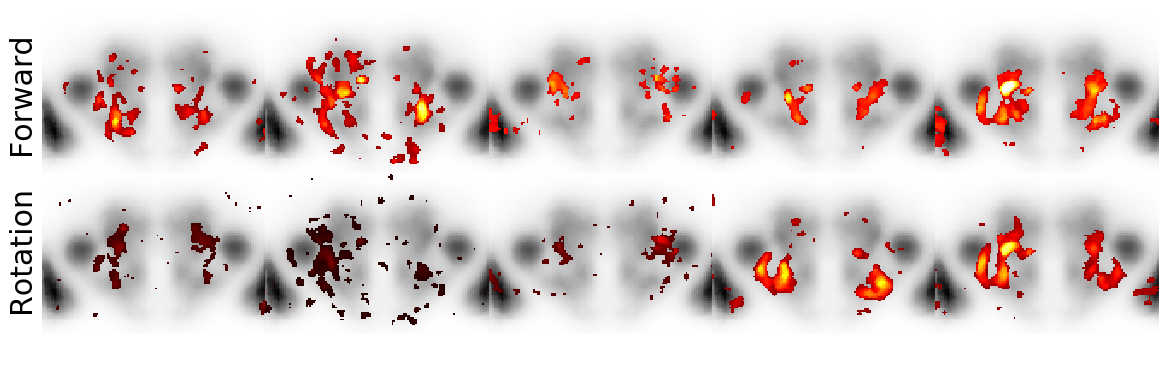

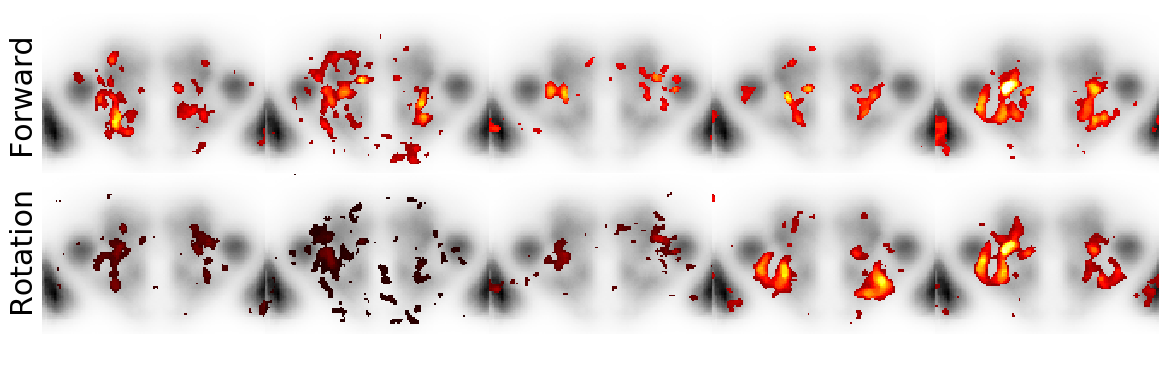

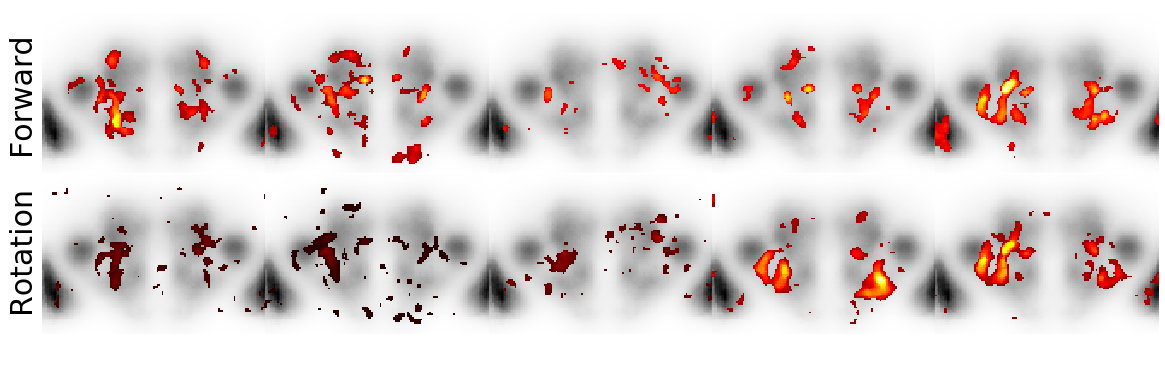

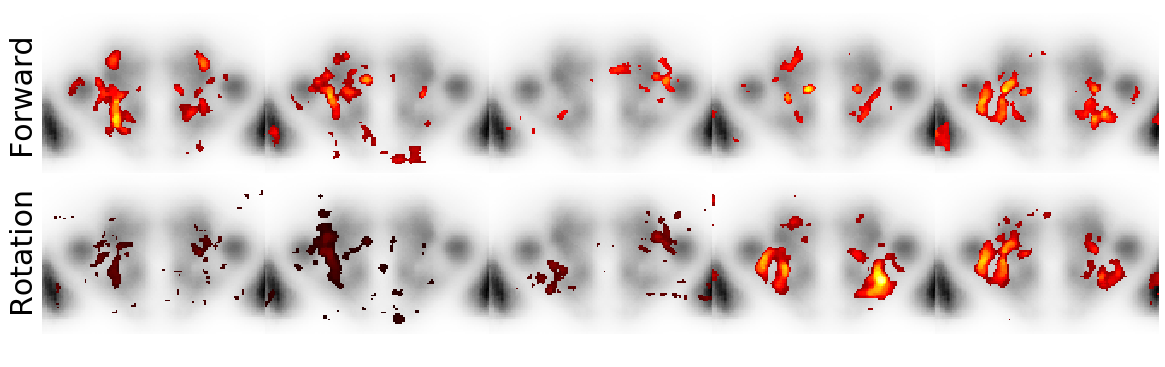

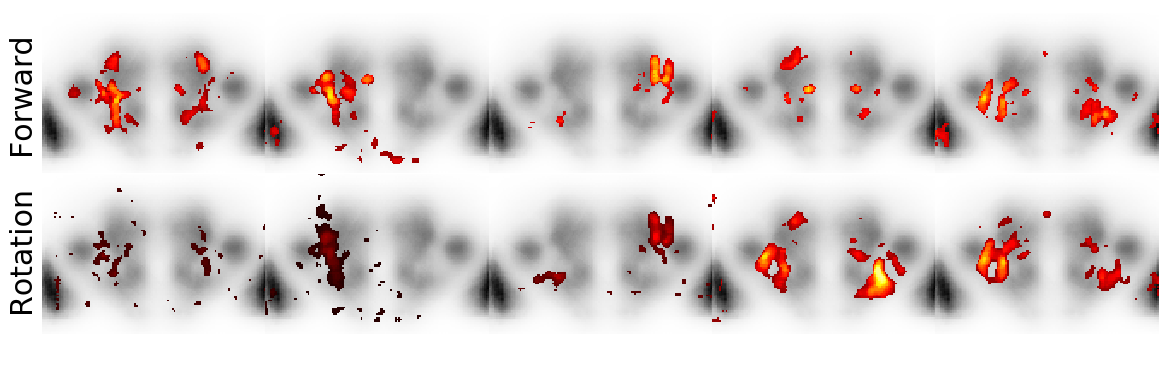

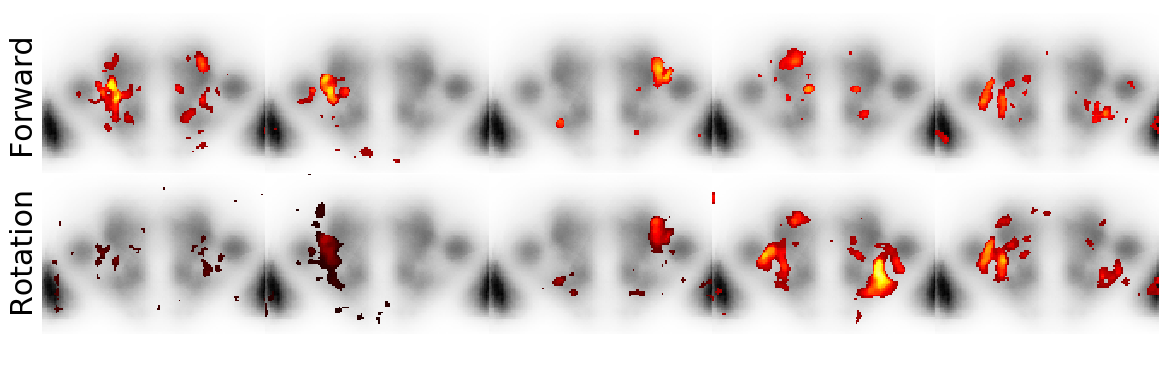

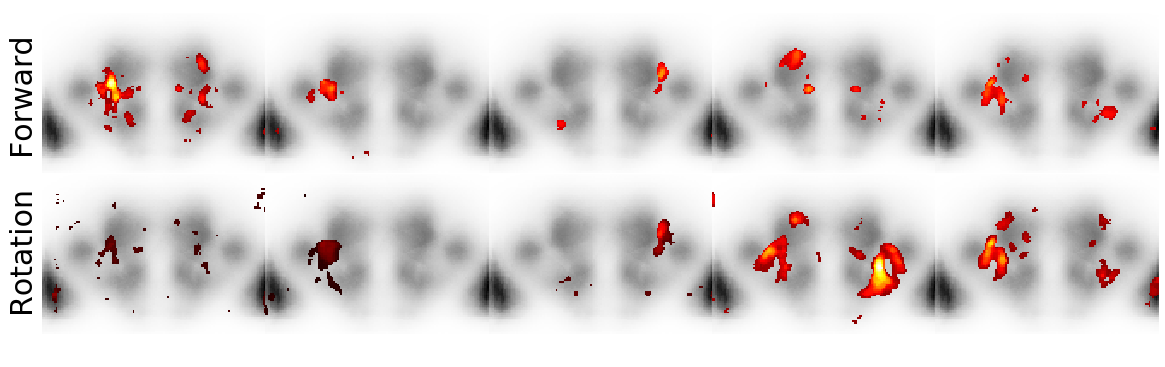

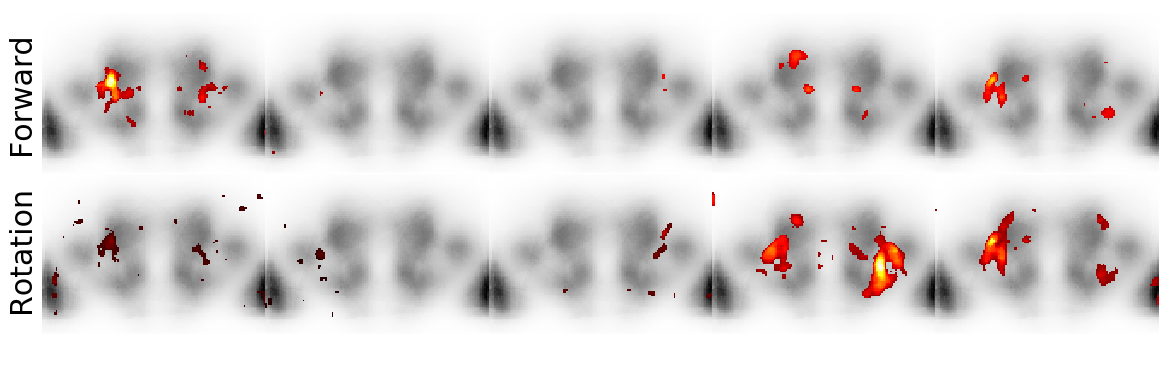

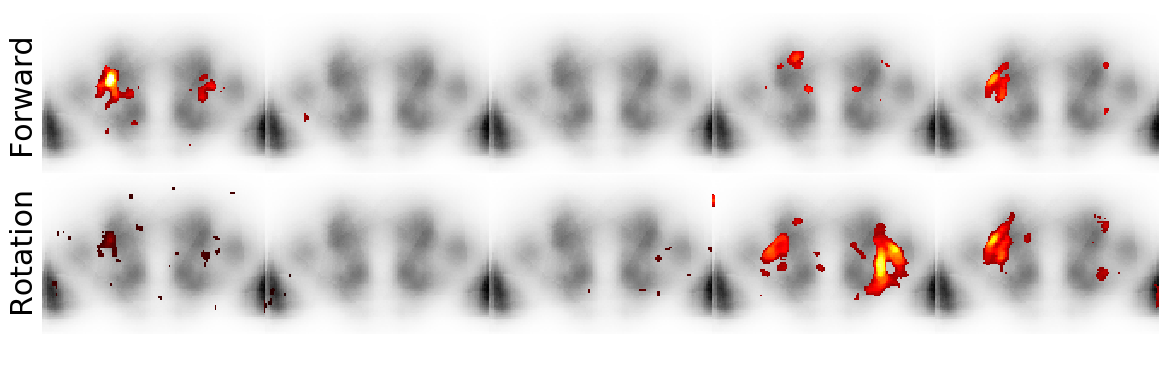

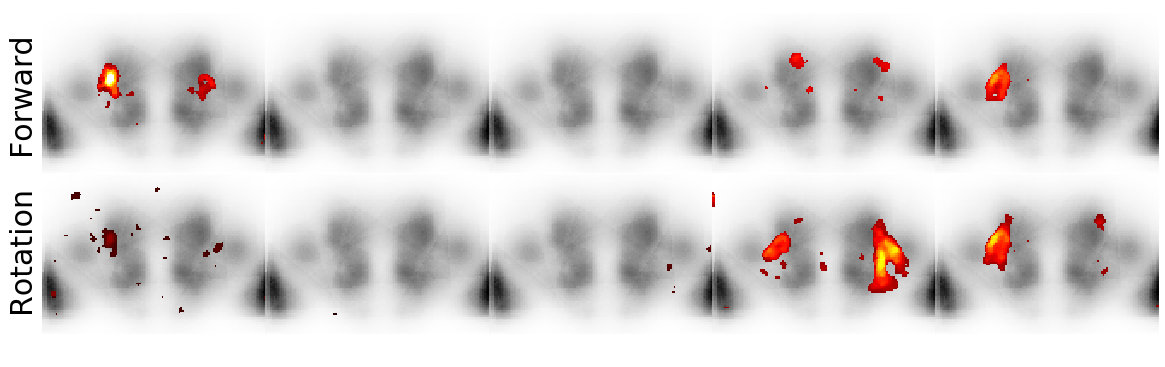

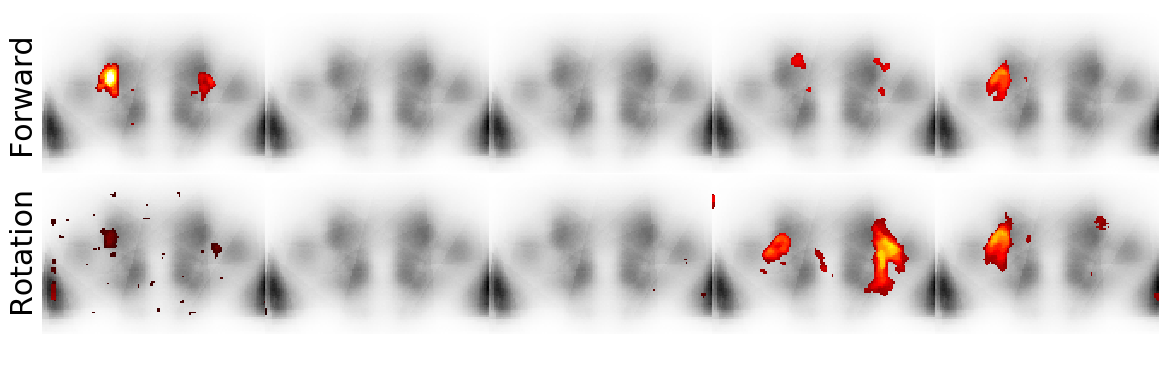

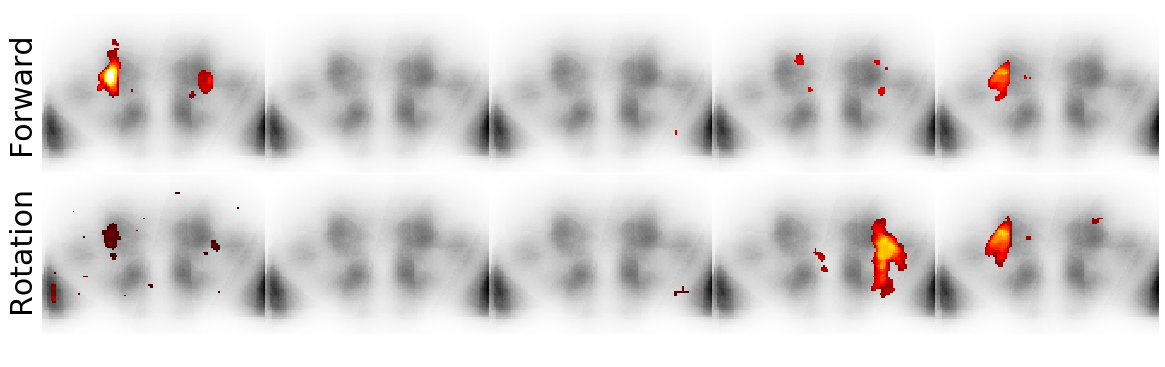

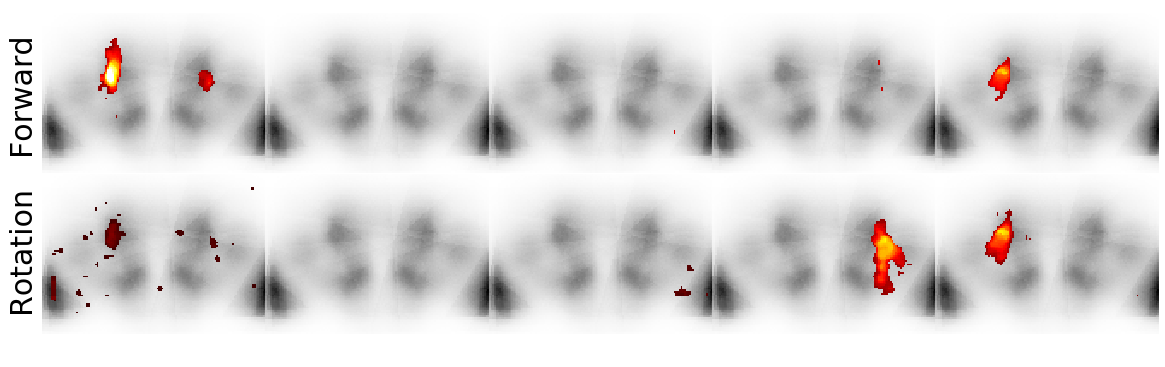

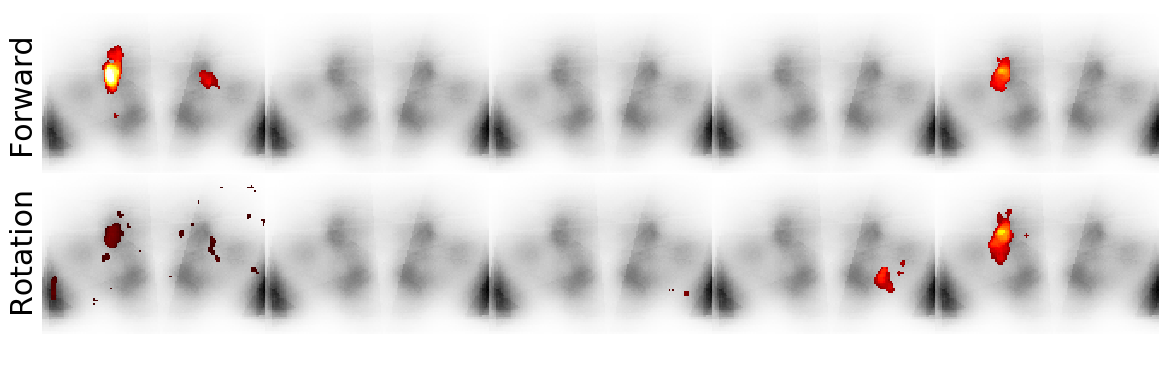

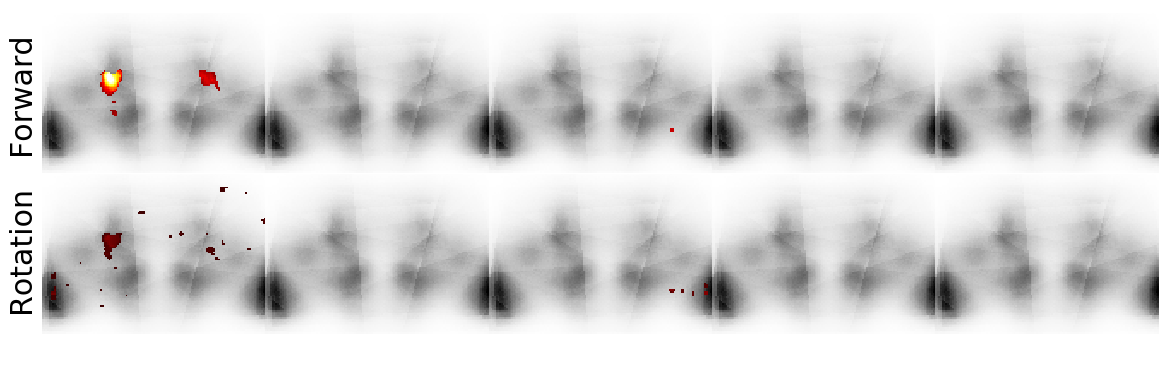

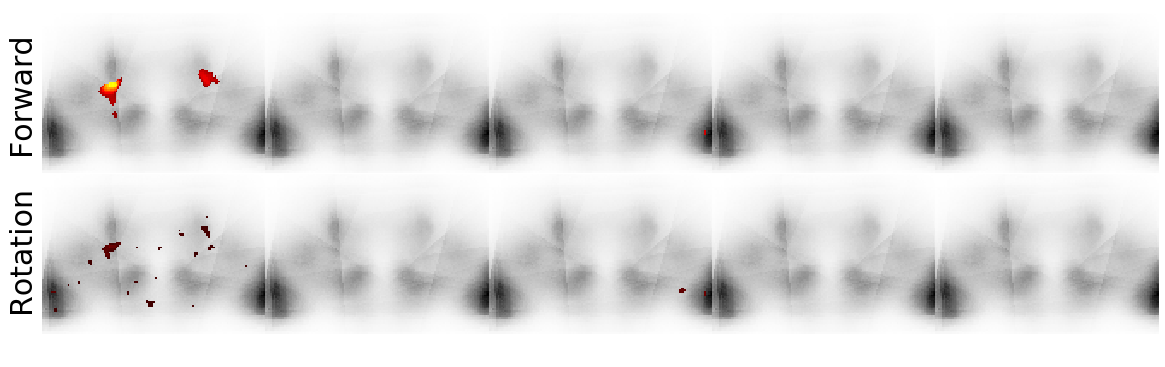

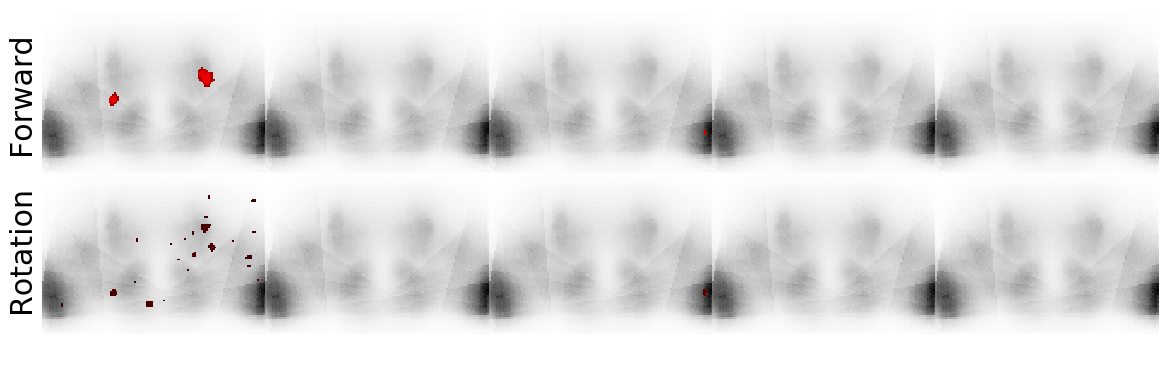

In [110]:
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs/20191110_movie_individual_maps_crop'
os.mkdir(save_path)
t0 = time.time()
for i in range(15,84):
    print(i)
    plt.figure(figsize=(20,5.9))
    for k,fly in enumerate(good_flies):
        ax = plt.subplot(2,5,k+1)
        ax.imshow(meanbrain_to_plot[:,:,i], cmap='Greys')
        filtered = ndimage.median_filter(np.nan_to_num(to_plot['Y'][fly][:,:,i]),size=4)
        filtered[filtered == 0] = np.nan
        ax.imshow(filtered.T,cmap='hot',vmin=0,vmax=0.004)
        #ax.text(.05,.75,fly, transform=ax.transAxes)
        ax.axis('off')
    for k,fly in enumerate(good_flies):
        ax = plt.subplot(2,5,k+6)
        ax.imshow(meanbrain_to_plot[:,:,i], cmap='Greys')
        filtered = ndimage.median_filter(np.nan_to_num(to_plot['Z'][fly][:,:,i]),size=4)
        filtered[filtered == 0] = np.nan
        ax.imshow(filtered.T,cmap='hot',vmin=0,vmax=0.004)
        #ax.text(.05,.75,fly, transform=ax.transAxes)
        ax.axis('off')
    plt.text(-545,-70,'Forward',rotation=90,fontsize=30)
    plt.text(-545,20,'Rotation',rotation=90,fontsize=30)
    plt.subplots_adjust(wspace=0, hspace=0)
    fname = os.path.join(save_path, '{0:05d}.png'.format(i))
    plt.savefig(fname,dpi=100,bbox_inches='tight')
print(time.time()-t0)

In [46]:
from scipy import ndimage

In [ ]:
plt.figure(figsize=(20,10))
for i,fly in enumerate(flies):
    plt.subplot(2,5,i+1)
    plt.imshow(map2mean['Y'][fly].numpy()[:,:,80].T)
    plt.title(fly)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

# Lets quickly make a zslice plot for each fly map

In [205]:
fly = 'fly_1'
for fly in flies:
    
    print(maps_ants['Y'][fly].numpy().shape[-1])

55
53
49
55
49
53
43
45
47
49


In [207]:
np.divide(55,7)

7.857142857142857

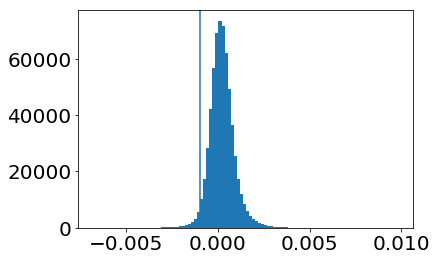

In [236]:
to_plot = maps_ants['Y'][fly].numpy()
plt.hist(to_plot.flatten(),bins=100);
plt.axvline(-.001)

In [237]:
to_plot = maps_ants['Y'][fly].numpy()
np.std(to_plot)

0.00068939175

In [227]:
to_plot.shape[0]

128

In [228]:
to_plot.shape[1]

88

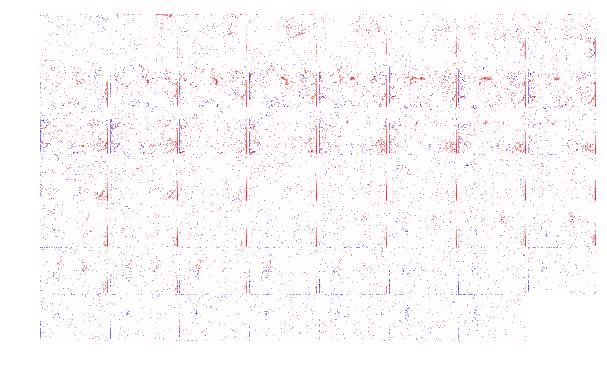

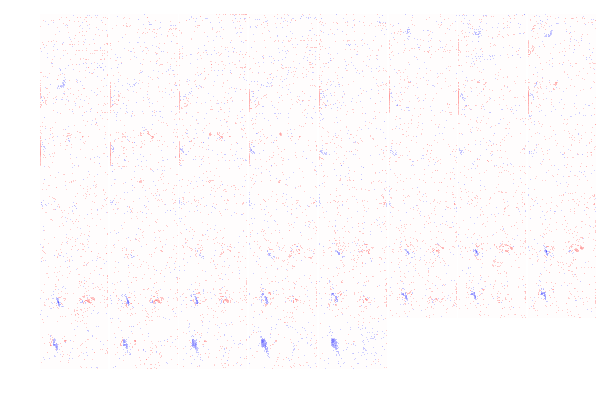

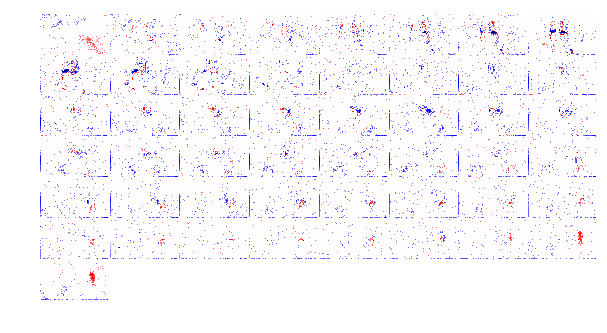

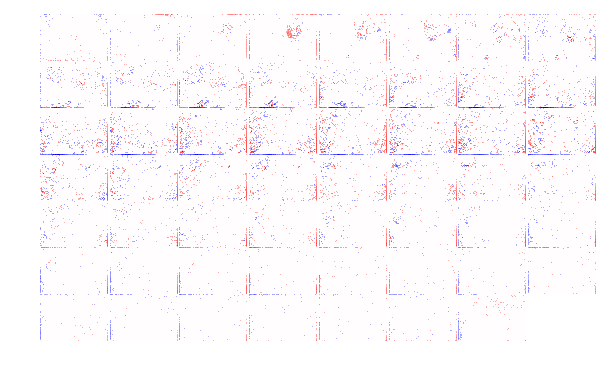

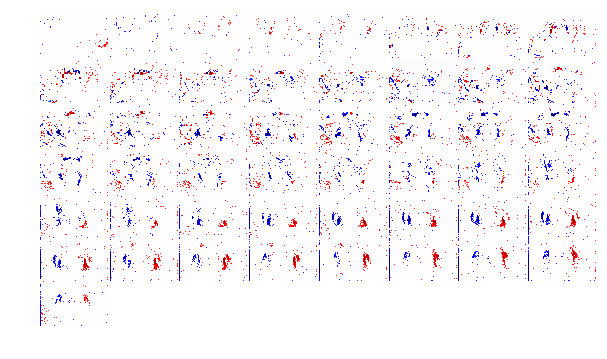

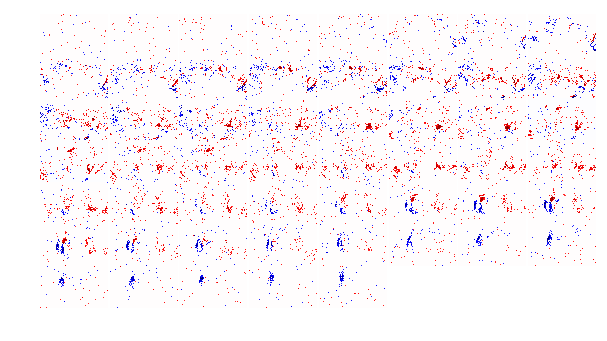

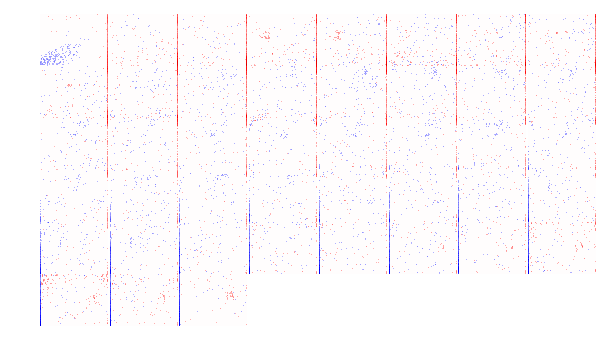

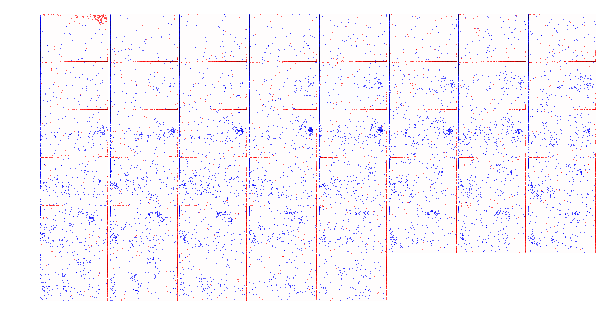

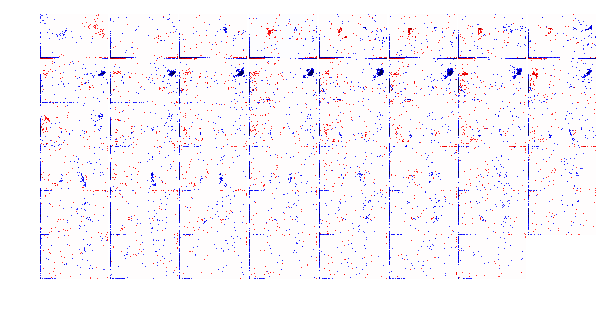

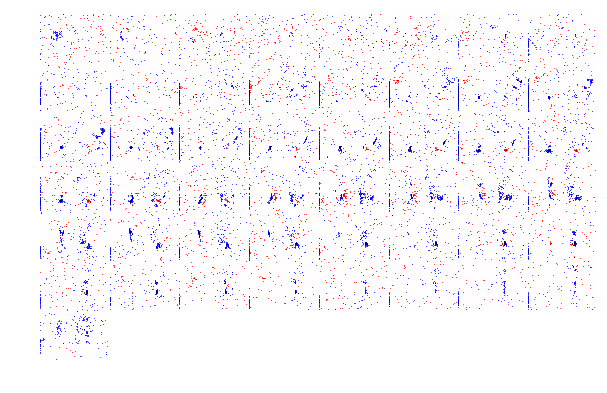

In [244]:
for fly in flies:
    to_plot = maps_ants['Z'][fly].numpy()

    thresh = np.std(to_plot) * 2
    low = to_plot > -thresh
    high = to_plot < thresh
    middle = low & high

    to_plot[middle] = 0

    plt.figure(figsize=(10,np.divide(to_plot.shape[1],to_plot.shape[0])*10))
    for i in range(to_plot.shape[-1]):
        ax = plt.subplot(8,8,i+1)
        ax.imshow(to_plot[:,:,i].T,cmap='seismic',vmin = -.004,vmax=.004)
        ax.axis('off')
        ax.set_aspect('equal')

    plt.subplots_adjust(wspace=0, hspace=0)

    save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
    timestr = time.strftime("%Y%m%d-%H%M%S")
    fname = os.path.join(save_path, timestr + '_{}_rotation.png'.format(fly))
    plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
bad_alignment_flies = ['fly_7', 'fly_51', ]

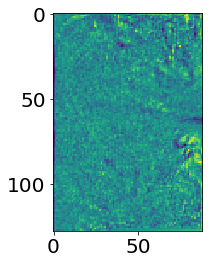

In [162]:
behavior = 'Y'
fly = 'fly_7'
plt.imshow(maps_ants[behavior][fly].numpy()[:,:,20])